In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
import arviz as az
from scipy.stats import norm
import scipy.stats as stats
from scipy.optimize import minimize
from mcmc_functions import logit_mh_mcmc, single_logit, general_logit, logit_ll, logit_lpd
from general_mhmcmc import general_mh_mcmc

In [2]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

In [3]:
data['DATE'] =  pd.to_datetime(data['YEAR'].astype(int).astype(str) + data['DAY'].astype(int).astype(str), format='%Y%j')
data['MONTH'] = data['DATE'].dt.to_period ('M')
data['WEEK'] = data['DATE'].dt.to_period('W')

dhaka_battles = data.loc[data['ADM2_name'] == 'Dhaka'].loc[data['EVENT_TYPE'] == 'Battles'].groupby('WEEK', as_index=False)[['RAW_COUNTS', 'FATALITIES']].sum()
dhaka_battles['BOOLEAN_FATAL'] = dhaka_battles['FATALITIES'].gt(0).astype('int')

In [4]:
list(dhaka_battles)

['WEEK', 'RAW_COUNTS', 'FATALITIES', 'BOOLEAN_FATAL']

# Different fatality models

The aim of this notebook is to explore and discuss different possible models for the modelling of fatalities resulting from battle events in Dhaka. The findings presented in this notebook will be used to inform the direction of further analysis. The sampling performed in this notebook will be performed using my self-implemented Metropolis-Hastings algorithm, which is also discussed throughout.

## Model One: Logistic regression on events of the current week only

The first model that is considered is a logistic regression model on the number of battles in a week. The model is given as the following logistic regression equation

\begin{equation}
    p_i = p(S_i) = \frac{\exp(\alpha + \beta S_i)}{1+\exp(\alpha + \beta S_i)}
\end{equation}

where $p(S_i)$ is the proportion of weeks with $S_i$ battles which have an associated fatality. Normal priors are set for $\alpha$ and $\beta$, with $\alpha \sim N(0, v_\alpha^2)$ and $\beta \sim N(0, v_\beta^2)$.

The fatality indicators $F_i \sim Bern(p_i)$ with $p_i$ being given by the logistic regression equation, leading to the likelihood function being 

\begin{equation}
    L(F; \alpha, \beta) = \prod_{i=1}^N p_i^{F_i} (1-p_i)^{1-F_i}
\end{equation}

with associated log likelihood

\begin{equation}
    l(F; \alpha, \beta) = \sum_{i=1}^N \left(F_i \log(p_i) + (1-F_i) \log(1-p_i)\right).
\end{equation}

### Model One: MCMC sampling and diagnostics

Log likelihoods are used throughout these analyses for numerical stability.

In the code document `dhaka_battles_functions.py`, there are functions specified for the log prior likelihood, the log likelihood and the log posterior density for a flexible number of parameters and covariates in a logistic model. These functions are called in the implementation of the Metropolis-Hastings algorithm, which is also contained in that document. The below cell sets up the proposal distributions for use in the algorithm, and the subsequent cell extracts the correct data to be used in the algorithm.

In [5]:
def proposal_alpha(alpha, stepsize = 0.5):
    return np.random.normal(alpha, stepsize)

def proposal_beta(beta, stepsize = 0.5):
    return np.random.normal(beta, stepsize)

In [6]:
fatalities = dhaka_battles['BOOLEAN_FATAL'].values
battle_counts = dhaka_battles['RAW_COUNTS'].values

To start the algorithm in a place that helps it to converge, the below cell uses the data and the log posterior likelihood function to calculate the MLE for the two parameters.

In [7]:
def neg_llh(parameters, responses, observations):
    '''
    Negative log-likelihood function

    Arguments are as log_likelihood

    Returns the negative log likelihood
    '''
    llh = logit_ll(parameters, responses, observations)
    return -llh

initial_params = list(minimize(neg_llh, [0, 0], (fatalities, battle_counts), method='L-BFGS-B').x)

In [8]:
initial_params

[-4.761959377625156, 4.149949431529044]

Changing the stepsize used in the proposal distribution has an effect on the effective sample size of the sampled parameters. The following cells are an attempt to find the optimum stepsizes for each parameter in order to maximize the effective sample size. These cells are commented out as the first two create 10 chains of 100 iterations for each of 144 stepsize combinations, so take around 25 minutes each to evaluate on my machine.

In [9]:
%%script false --no-raise-error # comment this line out to make the cell run

parameter_names = ['ALPHA', 'BETA']
param_steps = [0.5, 0.5]                            # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1], [0, 1]]                           # standard deviations of the priors
proposal_dists = [proposal_alpha, proposal_beta]    # proposal distributions for the Metropolis-Hastings
iterations = 100                                  # number of iterations to take
reps = 10                                            # number of repeats to average over

mean_alpha_ess = np.zeros((12, 12))
mean_beta_ess = np.zeros((12, 12))

for alpha_step in range(1,13):
    for beta_step in range(1,13):
        alpha_ess_total = 0
        beta_ess_total = 0
        print(f'For an alpha step of {alpha_step/10} and a beta step of {beta_step/10}:')
        param_steps = [alpha_step/10, beta_step/10]
        for i in range(reps):
            full_chain = logit_mh_mcmc(fatalities, battle_counts,
                                parameter_names, initial_params, param_steps, hyperparams, proposal_dists,
                                target_dist = logit_lpd, iterations=100)
            alpha_ess_total += az.ess(full_chain['ALPHA'].values)
            beta_ess_total += az.ess(full_chain['BETA'].values)
        mean_alpha_ess[alpha_step-1, beta_step-1] = alpha_ess_total/5
        mean_beta_ess[alpha_step-1, beta_step-1] = beta_ess_total/5
        print(f'The average effective sample size for alpha is {alpha_ess_total/5}')
        print(f'The average effective sample size for beta  is {beta_ess_total/5}')
        print()
    print()

In [10]:
%%script false --no-raise-error # comment this line out to make the cell run

parameter_names = ['ALPHA', 'BETA']
param_steps = [0.5, 0.5]                            # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1], [0, 1]]                           # standard deviations of the priors
proposal_dists = [proposal_alpha, proposal_beta]    # proposal distributions for the Metropolis-Hastings
iterations = 100                                  # number of iterations to take
reps = 10

mean_alpha_ess2 = np.zeros((12, 12))
mean_beta_ess2 = np.zeros((12, 12))

for alpha_step in range(1,13):
    for beta_step in range(1,13):
        alpha_ess_total = 0
        beta_ess_total = 0
        print(f'For an alpha step of {alpha_step/10} and a beta step of {beta_step/10}:')
        param_steps = [alpha_step/10, beta_step/10]
        for i in range(reps):
            full_chain = logit_mh_mcmc(fatalities, battle_counts,
                                parameter_names, initial_params, param_steps, hyperparams, proposal_dists,
                                target_dist = logit_lpd, iterations=iterations)
            alpha_ess_total += az.ess(full_chain['ALPHA'].values)
            beta_ess_total += az.ess(full_chain['BETA'].values)
        mean_alpha_ess2[alpha_step-1, beta_step-1] = alpha_ess_total/reps
        mean_beta_ess2[alpha_step-1, beta_step-1] = beta_ess_total/reps
        print(f'The average effective sample size for alpha is {alpha_ess_total/reps}')
        print(f'The average effective sample size for beta  is {beta_ess_total/reps}')
        print()
    print()

In [11]:
%%script false --no-raise-error # comment this line out to make the cell run

np.min(mean_beta_ess-mean_beta_ess2)

param_names = ['ALPHA', 'BETA']

diff_arrays = [mean_alpha_ess-mean_alpha_ess2, mean_beta_ess-mean_beta_ess2]

for idx, param in enumerate(param_names):
    print(f'The mean difference in the recorded ESS for {param} is {np.mean(diff_arrays[idx])}')
    print(f'The mean absolute difference in the recorded ESS for {param} is {np.mean(abs(diff_arrays[idx]))}')
    print(f'The maximum absolute difference in the recorded ESS for {param} is {np.max(abs(diff_arrays[idx]))}')
    print()

In [12]:
%%script false --no-raise-error # comment this line out to make the cell run

overall_alpha_ess = (mean_alpha_ess + mean_alpha_ess2)/2
overall_beta_ess = (mean_beta_ess + mean_beta_ess2)/2

In [13]:
%%script false --no-raise-error # comment this line out to make the cell run

colours = [(10/16, 3/16, 5/16), (12/16, 6/16, 6/16), (14/16, 9/16, 4/16), (14/16, 13/16, 0/16), (9/16, 13/16, 5/16), (4/16, 13/16, 8/16),
           (2/16, 12/16, 11/16), (0/16, 11/16, 12/16), (0/16, 9/16, 12/16), (3/16, 6/16, 11/16), (6/16, 3/16, 9/16), (8/16, 1/16, 7/16)]

fig, ax = plt.subplots(2, figsize=(30,20))

x_axis = np.linspace(0.1, 1.2, 12)

for i in range(12):
    ax[0].plot(x_axis, overall_alpha_ess[i,:], label = rf'$\beta$ step = {(i+1)/10}', color = colours[i])
    ax[0].text(1.201, overall_alpha_ess[i,11], f'{(i+1)/10}')
    ax[1].plot(x_axis, overall_beta_ess[:,i], label = rf'$\alpha$ step = {(i+1)/10}', color = colours[i])
    ax[1].text(1.201, overall_beta_ess[11, i], f'{(i+1)/10}')

ax[0].set(xlabel=r'$\alpha$ stepsize',
          ylabel=r'$\mathrm{ESS}_\alpha$',
          title=r'Effect of changing stepsize on effective sample size for $\alpha$')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.show()

The lack of repeatability of this result does not aid in the finding of a good stepsize to use. However, it seems that using $0.7$ for both parameters does somewhat maximize overall the effective sample size

The below cell sets up the final required variables and implements the algorithm. The code for the algorithm automatically shows the proposal acceptance rate for each parameter. Further details about the implementation of the Metropolis-Hastings algorithm are available within the code document. The effective sample size is also displayed to give an initial MCMC diagnostic. The cell afterwards then displays the trace plots for each parameter, and also produces a pair plot for the two parameters.

In [14]:
parameter_names = ['ALPHA', 'BETA']
param_steps = [0.7, 0.7]                            # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1], [0, 1]]                           # standard deviations of the priors
proposal_dists = [proposal_alpha, proposal_beta]    # proposal distributions for the Metropolis-Hastings
iterations = 10000                                  # number of iterations to take

full_chain = logit_mh_mcmc(fatalities, battle_counts,
                             parameter_names, initial_params, param_steps, hyperparams, proposal_dists,
                             target_dist = logit_lpd, iterations=iterations)

alpha_ess = az.ess(full_chain['ALPHA'].values)
beta_ess = az.ess(full_chain['BETA'].values)
print(f'The effective sample size for alpha is {alpha_ess}')
print(f'The effective sample size for beta  is {beta_ess}')

Proposal acceptance rate of 0.312 for parameter ALPHA
Proposal acceptance rate of 0.3486 for parameter BETA
The effective sample size for alpha is 517.5104239159909
The effective sample size for beta  is 529.9587235087722


In [15]:
int(5.5)

5

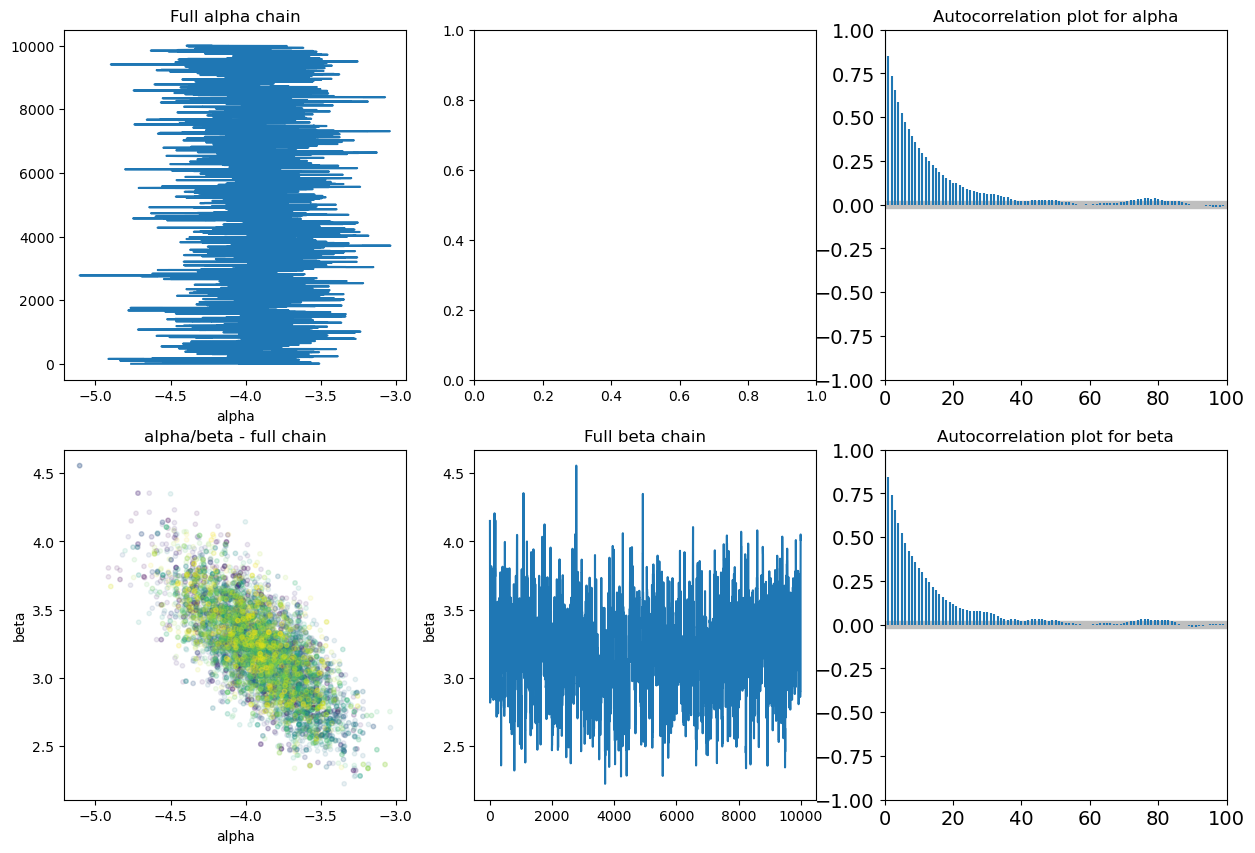

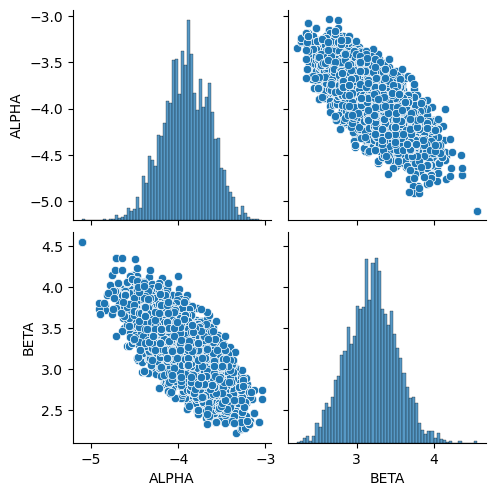

In [16]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0,0].plot(full_chain['ALPHA'], range(len(full_chain['ALPHA'])))
ax[0,0].set(title = 'Full alpha chain',
            xlabel = 'alpha')

ax[1,1].plot(full_chain['BETA'])
ax[1,1].set(title = 'Full beta chain',
            ylabel = 'beta')

ax[1,0].scatter('ALPHA', 'BETA', s=10, c=range(len(full_chain['ALPHA'])), alpha=0.1, data=full_chain)
ax[1,0].set(title = 'alpha/beta - full chain',
            xlabel = 'alpha',
            ylabel = 'beta')

az.plot_autocorr(full_chain['ALPHA'].values, ax=ax[0,2])
az.plot_autocorr(full_chain['BETA'].values, ax=ax[1,2])

ax[0,2].set(title = 'Autocorrelation plot for alpha')
ax[1,2].set(title = 'Autocorrelation plot for beta')

sns.pairplot(full_chain)
plt.show()

The effective sample sizes are fairly good for a chain of that length. Furthermore, the acceptance rates for both the parameters fall into a range which suggests that the sampler is adequately exploring the sample space whilst not spending too long in lower density regions. Furthermore, the sampled values do not form the assigned prior distributions for the parameters, which shows that the data are having an effect on the position of the posterior distribution.

A burn-in region of 1000 samples is then removed from the chain, and the MCMC diagnostics are then redone on the remainder of the chain, which is to be taken as the samples.

The effective sample size for alpha is 473.0144332411168
The effective sample size for beta  is 493.6172778280155


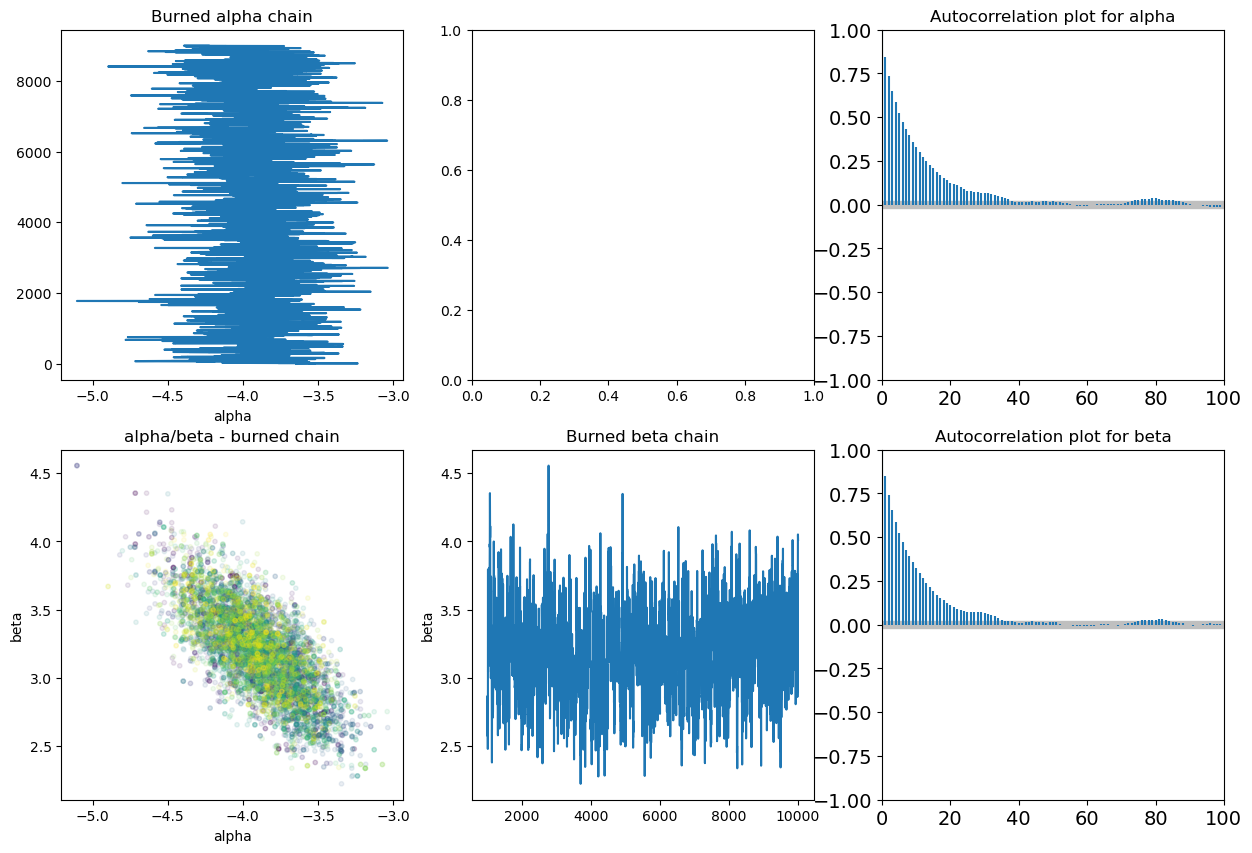

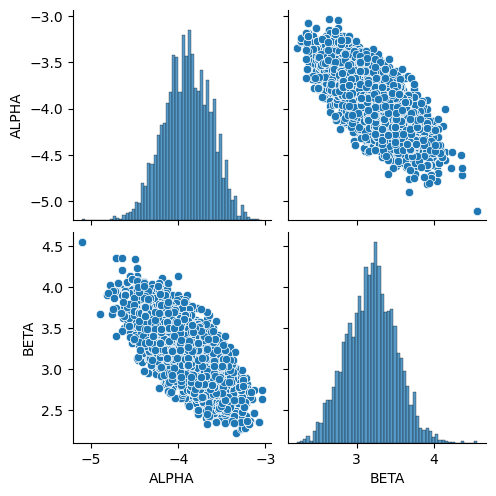

In [17]:
main_chain = full_chain.iloc[1001:]

# effective sample size
alpha_ess = az.ess(main_chain['ALPHA'].values)
beta_ess = az.ess(main_chain['BETA'].values)
print(f'The effective sample size for alpha is {alpha_ess}')
print(f'The effective sample size for beta  is {beta_ess}')

fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0,0].plot(main_chain['ALPHA'], range(len(main_chain['ALPHA'])))
ax[0,0].set(title = 'Burned alpha chain',
            xlabel = 'alpha')

ax[1,1].plot(main_chain['BETA'])
ax[1,1].set(title = 'Burned beta chain',
            ylabel = 'beta')

ax[1,0].scatter('ALPHA', 'BETA', s=10, c=range(len(main_chain['ALPHA'])), alpha=0.1, data=main_chain)
ax[1,0].set(title = 'alpha/beta - burned chain',
            xlabel = 'alpha',
            ylabel = 'beta')

az.plot_autocorr(main_chain['ALPHA'].values, ax=ax[0,2])
az.plot_autocorr(main_chain['BETA'].values, ax=ax[1,2])

ax[0,2].set(title = 'Autocorrelation plot for alpha')
ax[1,2].set(title = 'Autocorrelation plot for beta')

sns.pairplot(main_chain)
plt.show()

### Model One: Posterior analysis

Given the samples from the burned MCMC chain, it is now possible to draw conclusions from the posterior distribution of the $\alpha$ and $\beta$ parameters. The first thing that can be drawn is a plot of each of the logistic models $p(S_i)$ from each of the pairs of parameters sampled from the posterior distribution. The observed proportions of weeks with fatalities are plotted on the graph to illustrate a heuristic fit of the model to the data. 

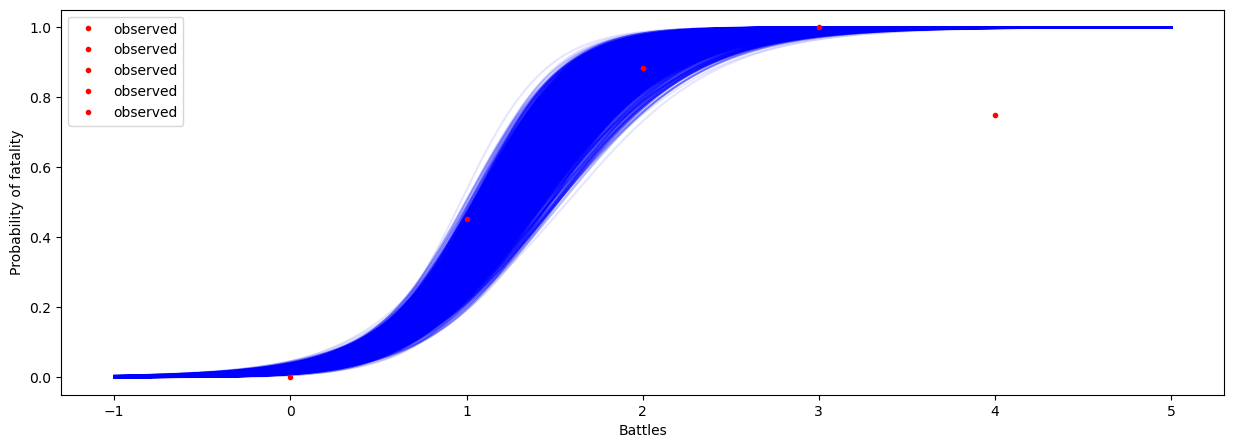

In [18]:
main_chain = main_chain.reset_index()

fig, ax = plt.subplots(figsize = (15, 5))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

centiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
centiles_collated = pd.DataFrame({'centiles':centiles})

for i, alpha in enumerate(main_chain['ALPHA']):
    beta = main_chain['BETA'][i]
    probs = single_logit(x_axis, [alpha, beta])
    ax.plot(x_axis, probs, c='b', alpha=0.1)

for i in range(5):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')
    
ax.set(xlabel='Battles',
       ylabel='Probability of fatality')

ax.legend(loc = 'best')

plt.show()

The model fits most of the data points relatively well. The outlier at $4$ battles in a week is due to there only being four such weeks for the model to be built upon, whilst there are many more weeks with one or two battles which influence the shape a lot more. Whilst the curves are extended beyond zero in this plots, anything that is interpreted from the model should take that $p_0=0$ as a week with no events will see no associated fatalities. 

The posterior distributions are then visualised by creating boxplots of the $p(S_i)$ values for each sampled $\alpha$ and $\beta$, and numbers of weekly events ranging from $0$ to $5$. These illustrate the range of sampled $p_i$ values.

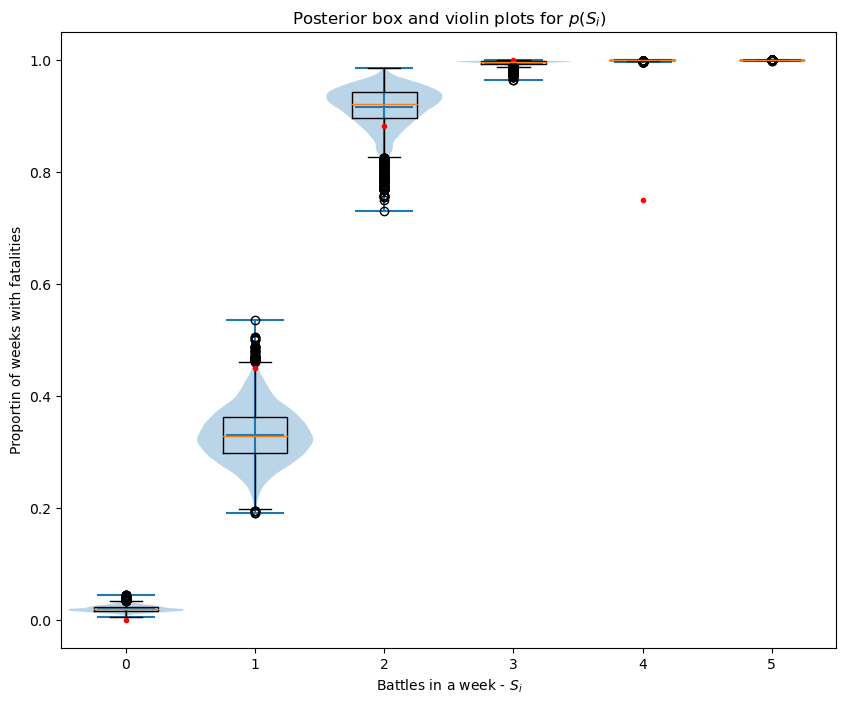

In [19]:
sim_battles = [0, 1, 2, 3, 4, 5]

results_mat = np.zeros((len(main_chain['ALPHA']), 6))

for i, alpha in enumerate(main_chain['ALPHA']):
    beta = main_chain['BETA'][i]
    for j in range(6):
        results_mat[i, j] = single_logit(j, [alpha, beta])

fig, ax = plt.subplots(figsize = (10, 8))

ax.violinplot(results_mat, widths=0.9, showmeans=True, positions=sim_battles)
ax.boxplot(results_mat, widths=0.5, positions=sim_battles)

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')

ax.set(title=r'Posterior box and violin plots for $p(S_i)$',
       xlabel = r'Battles in a week - $S_i$',
       ylabel = 'Proportin of weeks with fatalities')

plt.show()

## Model Two: Logistic regression considering the fatalities of the previous week

We now consider a logistic regression on not only the number of battles in a week but also on an indicator of whether there was a fatality the previous week. To consider this model, it is first necessary to add a column to the data frame, which is a 1 if there was a fatality in the previous week, and a 0 otherwise. This is implemented in the following code cell.

In [20]:
dhaka_battles['PREV_WEEK'] = (dhaka_battles['BOOLEAN_FATAL'].shift(1) > 0).astype(int)

The model that is now being considered is very similar to Model One, but with an extra parameter in the logistic regression:

\begin{equation}
    p_i = p(S_i, F_{i-1}) = \frac{\exp(\alpha + \beta S_i + \gamma F_{i-1})}{1+\exp(\alpha + \beta S_i + \gamma F_{i-1})}.
\end{equation}

Apart from now being dependent on the $\gamma$ parameter, the log likelihood takes the same form as before, and the $\gamma$ parameter is assigned a normal prior. The response variables and covariates have the first row removed, since there is no data for fatalities in the week before the first week. This is implemented in the next code cell.

### Model Two: MCMC sampling and diagnosis

The sampling proceeds as before: first the MLE estimate of the parameters is found, and then the MCMC algorithm takes this as the first sample. The proposal distributions remain Normal with variances selected to maintain good proposal acceptance rates.

In [21]:
initial_params = list(minimize(neg_llh, [0, 0], (fatalities, battle_counts), method='L-BFGS-B').x)

In [22]:
prev_fatalities = dhaka_battles['PREV_WEEK'].values[1:]
mod2_covs = np.zeros((len(prev_fatalities), 2))
mod2_covs[:,0] = battle_counts[1:]
mod2_covs[:,1] = prev_fatalities
mod2_fatalities = fatalities[1:]

In [23]:
def proposal_gamma(gamma, stepsize=0.5):
    return np.random.normal(gamma, stepsize)

initial_params = list(minimize(neg_llh, [0,0,0], (mod2_fatalities, mod2_covs), method='L-BFGS-B').x)

In [24]:
initial_params

[-4.895270066606227, 4.139701505724295, 1.0189506009955054]

In [25]:
parameter_names = ['ALPHA', 'BETA', 'GAMMA']
param_steps = [0.7, 0.7, 1.0]                                       # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1], [0, 1], [0, 1]]                            # hyperparameters - mean, sd for the priors
proposal_dists = [proposal_alpha, proposal_beta, proposal_gamma]    # proposal distributions for the Metropolis-Hastings
iterations = 10000                                                   # number of iterations to take

full_chain = logit_mh_mcmc(mod2_fatalities, mod2_covs,
                           parameter_names, initial_params, param_steps, hyperparams,
                           proposal_dists, target_dist=logit_lpd, iterations=iterations)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

Proposal acceptance rate of 0.3116 for parameter ALPHA
Proposal acceptance rate of 0.3422 for parameter BETA
Proposal acceptance rate of 0.4624 for parameter GAMMA
Effective sample size of 573.513335255476 for parameter ALPHA
Effective sample size of 598.2007317033418 for parameter BETA
Effective sample size of 2037.186507551718 for parameter GAMMA


The addition of the new parameter has increased the effective sample sizes for the other parameters, whilst the $\gamma$ parameter has a noticeably higher effective sample size. This seems to be unchnging under different stepsizes. The stepsizes being used here were found by repeating the chain and finding values which had higher effective sample sizes in comparison to others but which maintained the acceptance ratio between 0.2 and 0.6 for all parameters.

Having performed the required sampling, the below cell plots trace plots, autocorrelation and pairplots for the sampled parameters to provide a visual assessment of the sampler.

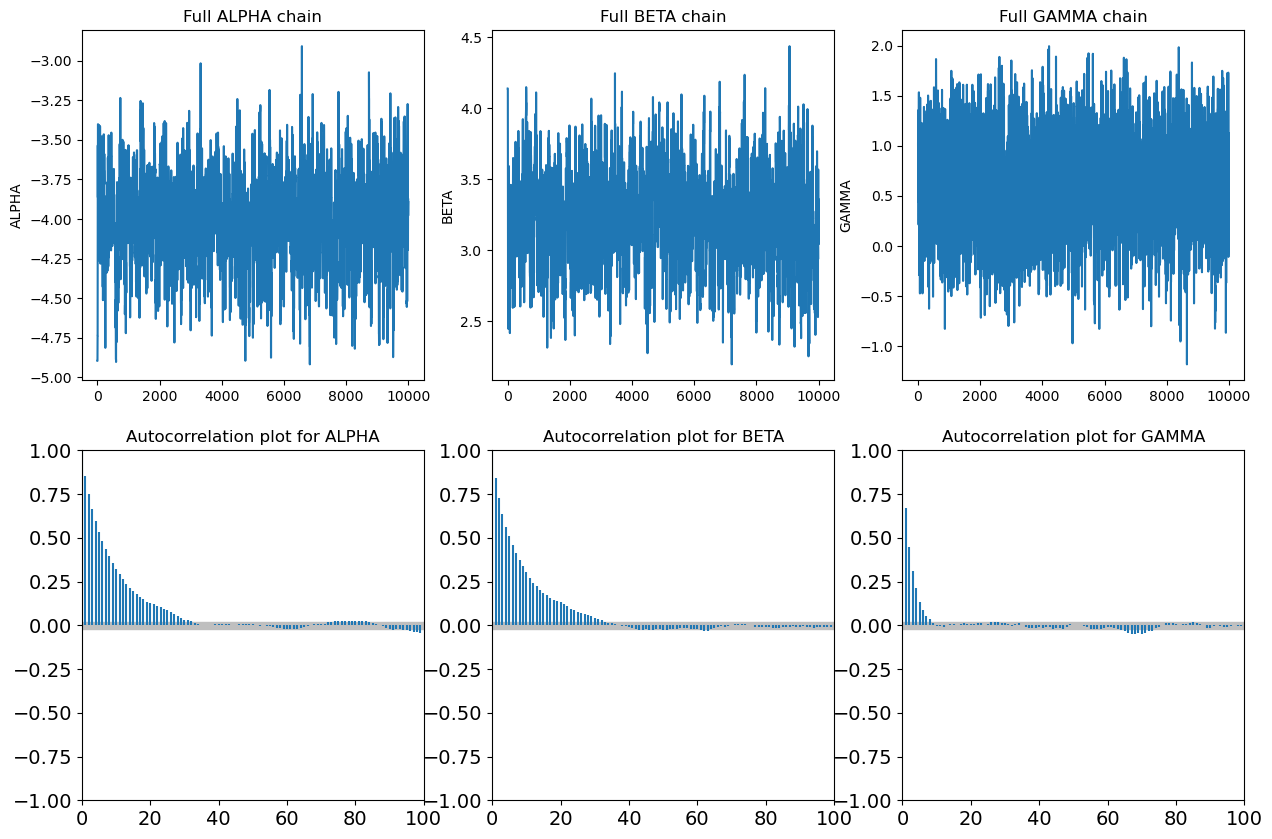

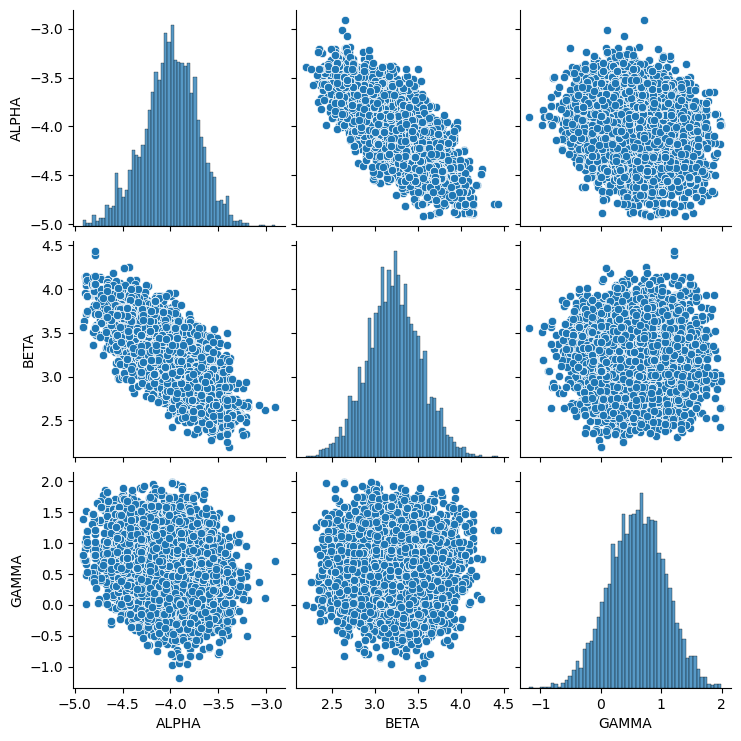

In [26]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(parameter_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}') 
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

sns.pairplot(full_chain)
plt.show()

Once again it is clear that the data have had an effect on the position of the posterior distributions in comparison to the priors. The $\alpha$ and $\beta$ posteriors have not moved much from the previous model. The $\gamma$ posterior distribution still has a mean near $0$ which suggests that the previous week's fatalities do not have a huge effect on the model.

Once again 1000 samples are burned from the beginning of the chain and further posterior analysis is conducted.

Effective burned sample size of 554.7317862604637 for parameter ALPHA
Effective burned sample size of 565.6210791133012 for parameter BETA
Effective burned sample size of 1876.019720432307 for parameter GAMMA


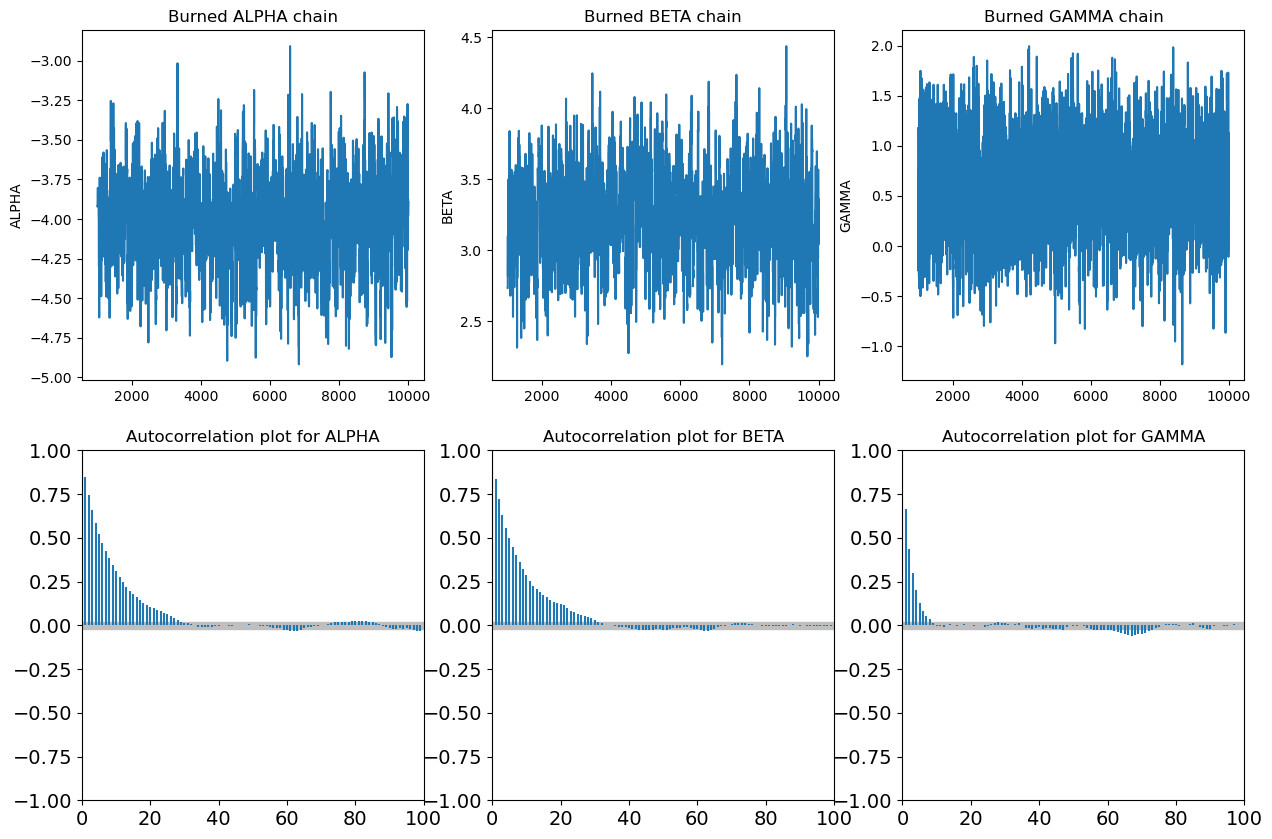

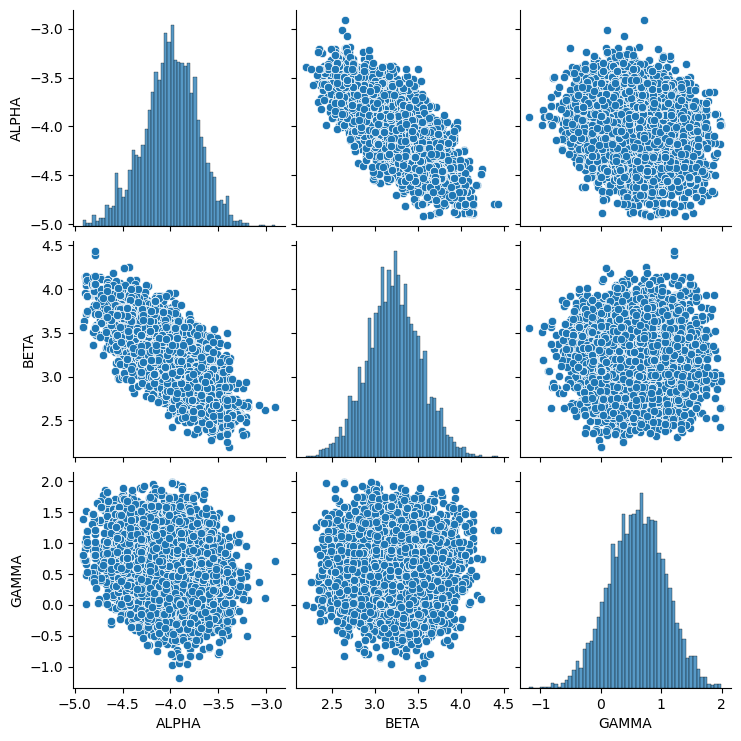

In [27]:
main_chain = full_chain.iloc[1001:]

for idx, param in enumerate(parameter_names):
    ess = az.ess(main_chain[param].values)
    print(f'Effective burned sample size of {ess} for parameter {param}')

fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(parameter_names):
    ax[0, idx].plot(main_chain[param])
    az.plot_autocorr(main_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Burned {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

sns.pairplot(full_chain)
plt.show()

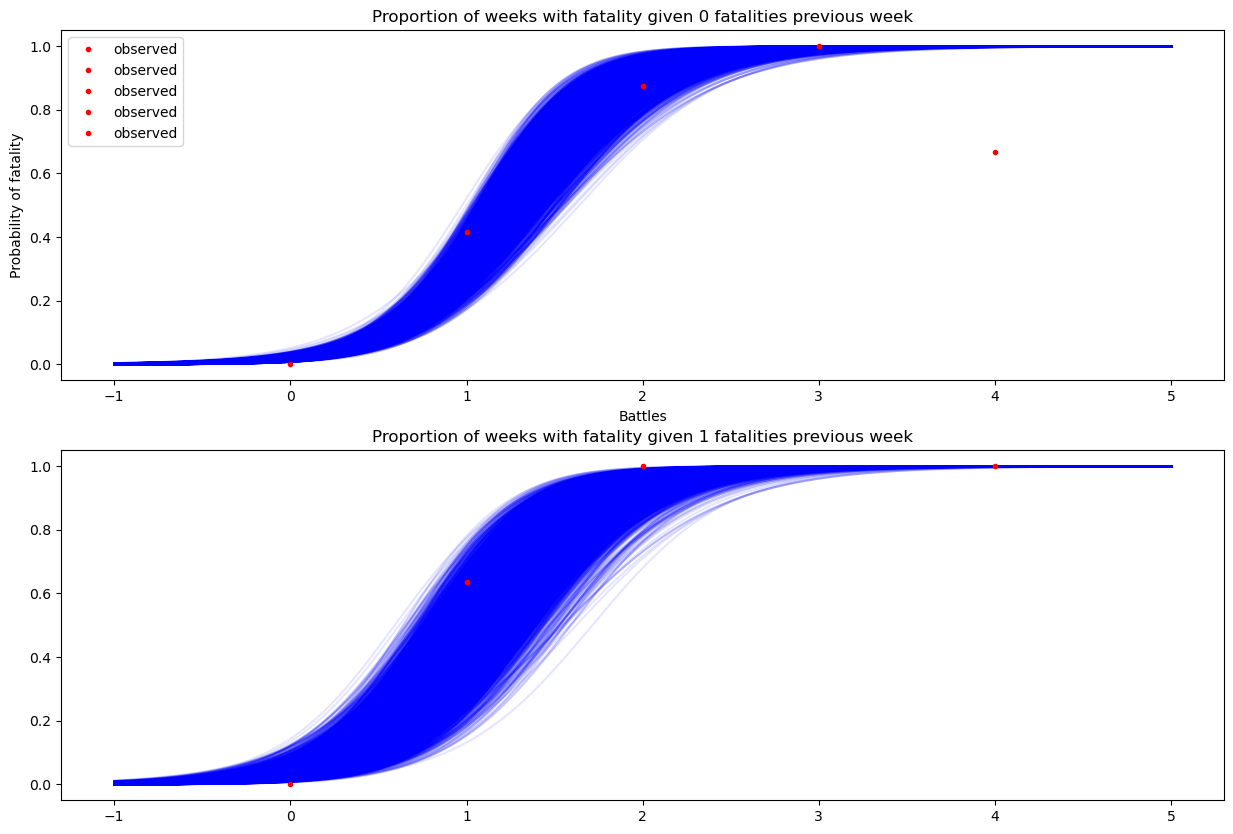

In [28]:
main_chain = main_chain.reset_index()

fig, ax = plt.subplots(2, figsize = (15, 10))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

for idx in range(2):
    for i, alpha in enumerate(main_chain['ALPHA']):
        beta = main_chain['BETA'][i]
        gamma = main_chain['GAMMA'][i]
        probs = general_logit([x_axis, idx], [alpha, beta, gamma])
        ax[idx].plot(x_axis, probs, c='b', alpha=0.1)
    ax[idx].set(title = f'Proportion of weeks with fatality given {idx} fatalities previous week')
    for i in range(5):
        total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx])
        fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
        if total != 0:
            ax[idx].plot(i, fatal/total, 'r.', label='observed')
    
ax[0].set(xlabel='Battles',
       ylabel='Probability of fatality')

ax[0].legend(loc = 'best')

plt.show()

In this scenario, two plots must be shown, to split the data into weeks with and without a fatality in the preceding week. These plots show how the posterior distributions once again fit the data fairly well, without outliers explained by very feww real-life observations. Furthermore, the effect of the $\gamma$ parameter on the posterior distribution is clear to see, as the lower plot is much more spread out than the upper. There is once again the problem of observing fatalities in the posterior with no events in a week, which is exacerbated by the inclusion of the $\gamma$ parameter in the logistic regression. 

Below we once again see box and violin plots for the posterior distribution of the proportion of fatalities given a certain number of weekly events, and now also based on the absence or occurence of fatalities in the previous week.

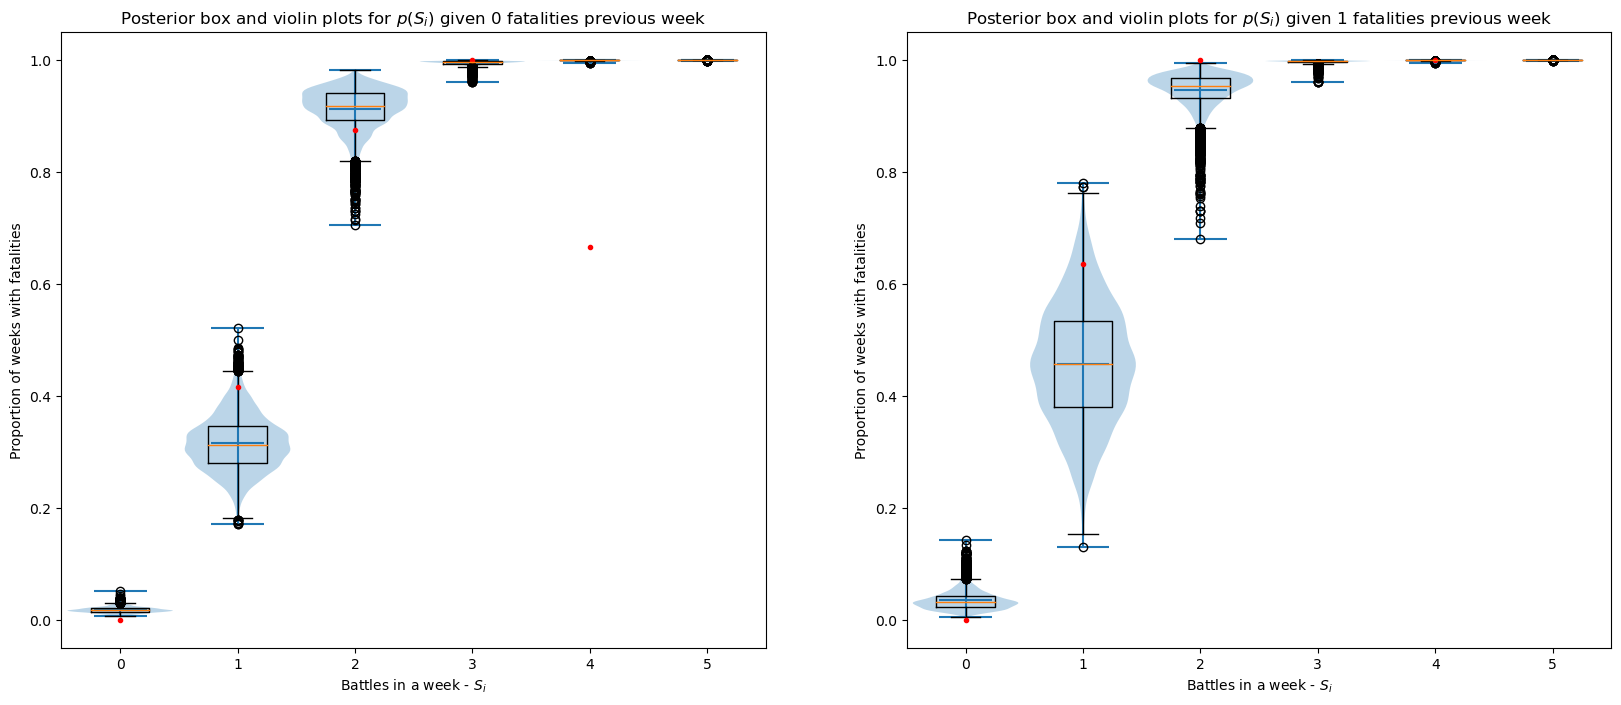

In [29]:
sim_battles = [0, 1, 2, 3, 4, 5]

results_mat0 = np.zeros((len(main_chain['ALPHA']), 6))
results_mat1 = np.zeros((len(main_chain['ALPHA']), 6))

for i, alpha in enumerate(main_chain['ALPHA']):
    beta = main_chain['BETA'][i]
    gamma = main_chain['GAMMA'][i]
    for j in range(6):
        results_mat0[i, j] = general_logit([j, 0], [alpha, beta, gamma])
        results_mat1[i, j] = general_logit([j, 1], [alpha, beta, gamma])

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

results = [results_mat0, results_mat1]

for idx in range(2):
    ax[idx].violinplot(results[idx], widths=0.9, showmeans=True, positions=sim_battles)
    ax[idx].boxplot(results[idx], widths=0.5, positions=sim_battles)
    ax[idx].set(title=rf'Posterior box and violin plots for $p(S_i)$ given {idx} fatalities previous week',
              xlabel = r'Battles in a week - $S_i$',
              ylabel = 'Proportion of weeks with fatalities')
    for i in range(6):
        total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx])
        fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
        if total != 0:
            ax[idx].plot(i, fatal/total, 'r.', label='observed')


plt.show()

Most of the oberseved data points lie within the posterior distributions for the proportion of weeks with fatalities given a certain number of events in a week. There are a relatively small number of data points at this level so the observed points which lie outside the posterior distributions can be explained by considering the additional uncertainty in the observations. Given $N_k$ weeks with $k$ events, the number of weeks which saw a fatality, $X_k$, can be considered as a draw from a binomial distribution - $\mathrm{Binom}(N_k, p_k)$ - where $p_k$ is the associated probabilty that a week with $k$ events sees a fatality. This can be implemented to provide better posterior predictions of the probability of a fatality given a certain number of events.

Another issue with the posterior distributions is that the probability of a fatality when observing a week with no events does not come out to be zero. In fact, when there has been a fatality the previous week, the maximum proportion observed in the samples is around $0.15$, with a mean somewhere around $0.05$ which is a result that is inconsistent with the observations and also with the real world. A suggested solution to this is to remove the weeks with zero events from the dataset and re-run the sampling algorithm. This is implemented in the cells that follow.

In [30]:
mod2a_covs = dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] != 0][['RAW_COUNTS', 'PREV_WEEK']].values[1:]
mod2a_fatalities = dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] != 0]['BOOLEAN_FATAL'].values[1:]

initial_params = list(minimize(neg_llh, [0,0,0], (mod2a_fatalities, mod2a_covs), method='L-BFGS-B').x)

In [31]:
initial_params

[-1.4474418016090036, 1.2411104061603149, 0.8244120628204942]

In [32]:
parameter_names = ['ALPHA', 'BETA', 'GAMMA']
param_steps = [0.5, 0.5, 1.0]                                       # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1], [0, 1], [0, 1]]                            # hyperparameters - mean, sd for the priors
proposal_dists = [proposal_alpha, proposal_beta, proposal_gamma]    # proposal distributions for the Metropolis-Hastings
iterations = 10000                                                   # number of iterations to take

full_chain = logit_mh_mcmc(mod2a_fatalities, mod2a_covs,
                           parameter_names, initial_params, param_steps, hyperparams,
                           proposal_dists, target_dist=logit_lpd, iterations=iterations)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

Proposal acceptance rate of 0.4516 for parameter ALPHA
Proposal acceptance rate of 0.3648 for parameter BETA
Proposal acceptance rate of 0.5124 for parameter GAMMA
Effective sample size of 342.9180657760928 for parameter ALPHA
Effective sample size of 330.0800055641469 for parameter BETA
Effective sample size of 1897.0441679689343 for parameter GAMMA


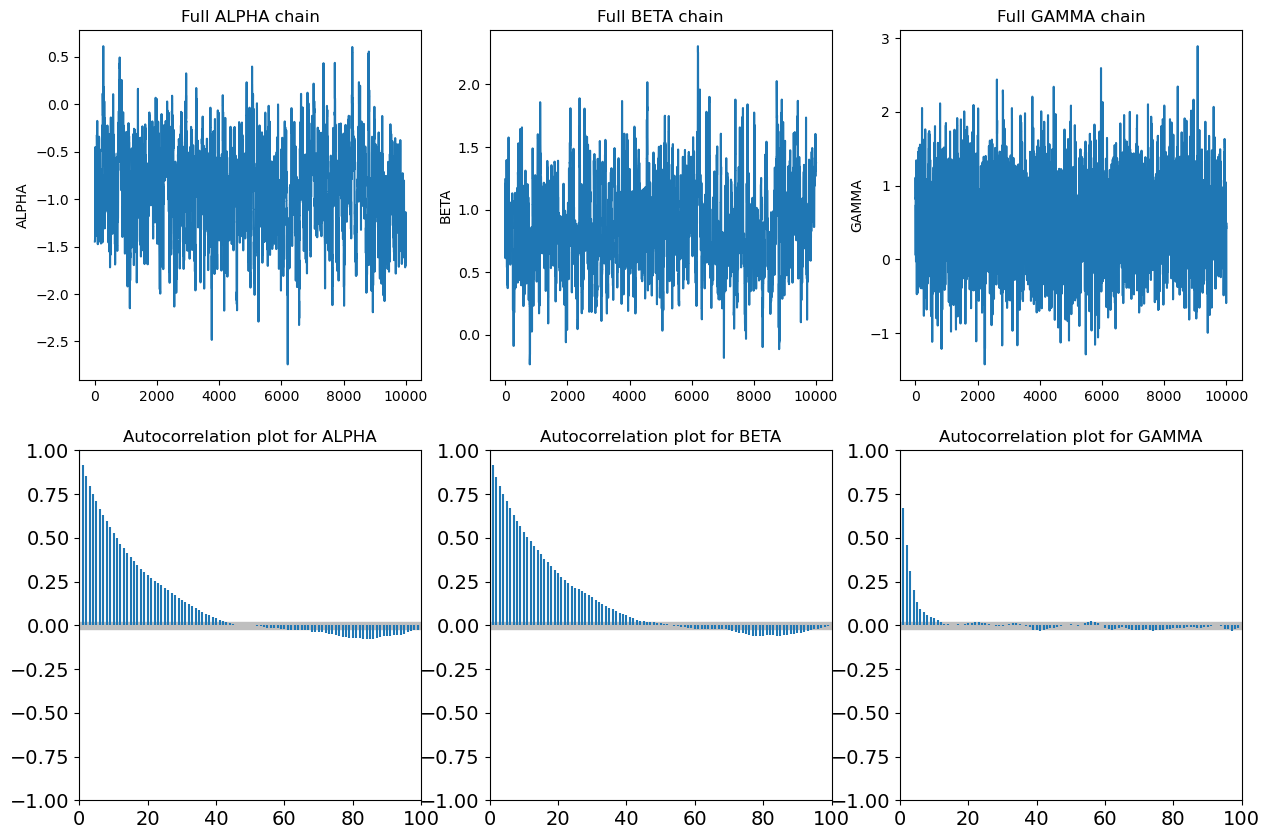

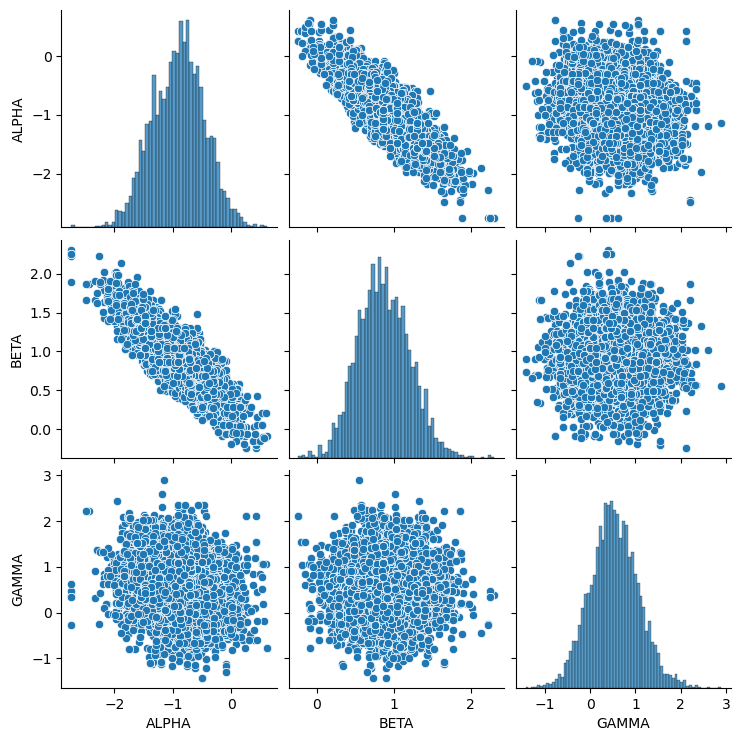

In [33]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(parameter_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

sns.pairplot(full_chain)
plt.show()

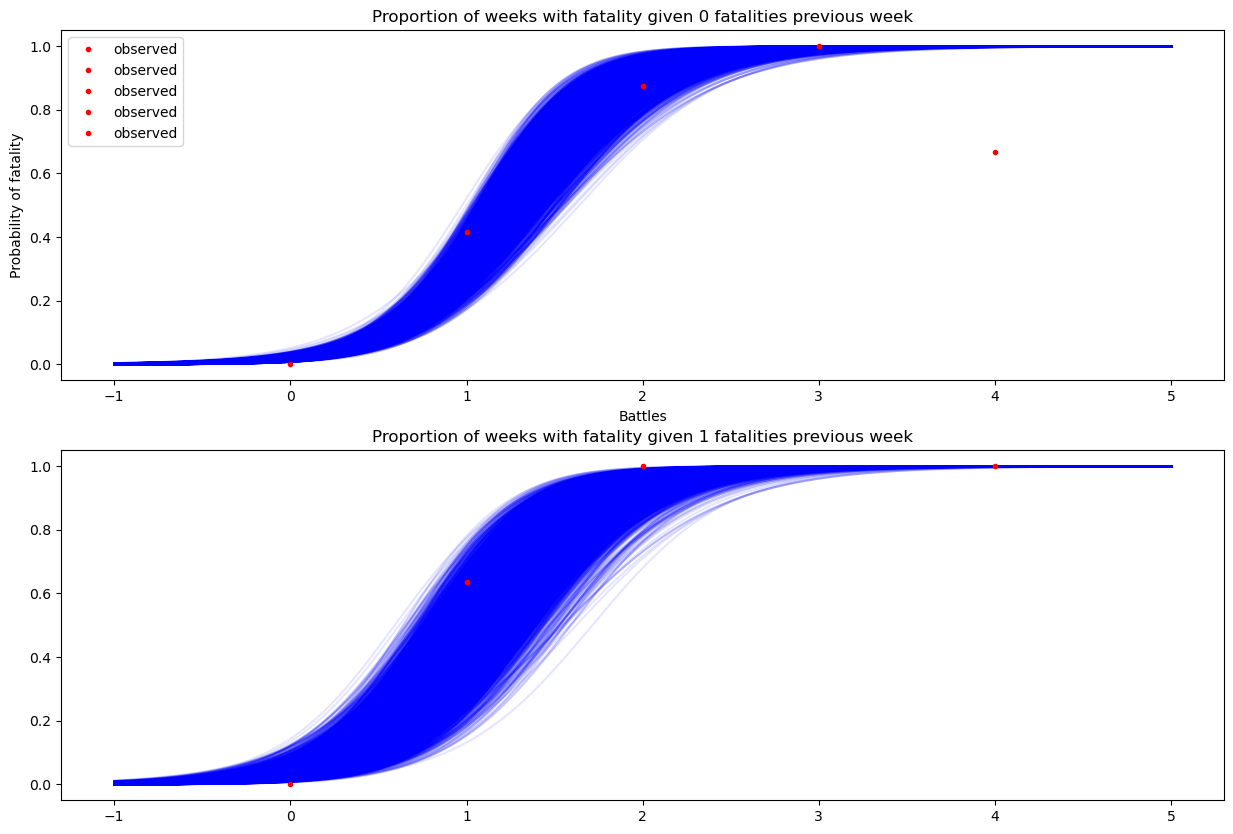

In [34]:
main_chain = main_chain.reset_index()

fig, ax = plt.subplots(2, figsize = (15, 10))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

for idx in range(2):
    for i, alpha in enumerate(main_chain['ALPHA']):
        beta = main_chain['BETA'][i]
        gamma = main_chain['GAMMA'][i]
        probs = general_logit([x_axis, idx], [alpha, beta, gamma])
        ax[idx].plot(x_axis, probs, c='b', alpha=0.1)
    ax[idx].set(title = f'Proportion of weeks with fatality given {idx} fatalities previous week')
    for i in range(5):
        total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx])
        fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['PREV_WEEK'] == idx].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
        if total != 0:
            ax[idx].plot(i, fatal/total, 'r.', label='observed')
    
ax[0].set(xlabel='Battles',
       ylabel='Probability of fatality')

ax[0].legend(loc = 'best')

plt.show()

# Model Three: Discretisation of number of events

In the third model we discretise the number of events in a week, where the proportion of weeks with a fatality is modelled as $p_j, j=0,1,2,3+$ where $j$ is the number of events. This allows setting of $p_0=0$ which is the only value that makes sense - a week with no battles will have no fatalities.

The prior distributions are given as 

\begin{equation}
p_j \sim \mathrm{Beta}(\alpha_1, \alpha_2) = \frac{\Gamma\left(\alpha_1+\alpha_2\right)p_j^{\alpha_1-1}(1-p_j)^{\alpha_2-1}}{\Gamma\left(\alpha_1\right)\Gamma\left(\alpha_2\right)},
\end{equation}

 and setting $\alpha_1=\alpha_2=1$ gives a uniform prior on $[0,1]$.

In week $i$ the indication of whether there is a fatality is $\mathbb{P}\left(F^{(i)}|S_t=j\right)\sim\mathrm{Bern}(p_j)$. Given $N$ weeks with $j$ events this means the likelihood is given by 

\begin{equation}
p(F_j|p_j) = \prod\limits_{i=1}^Np_j^{F_j^{(i)}}(1-p_j)^{1-F_j^{(i)}}
\end{equation}

where $F_j^{(i)}$ represents the fatality indication of the $i^\mathrm{th}$ week with $j$ events.

Combining the prior and the likelihood reveals the form of the posterior distribution:

\begin{equation}
\begin{split}  
    \pi(p_j|F_j) &= \frac{\Gamma\left(\alpha_1+\alpha_2\right)p_j^{\alpha_1-1}(1-p_j)^{\alpha_2-1}}{\Gamma\left(\alpha_1\right)\Gamma\left(\alpha_2\right)}\prod\limits_{i=1}^Np_j^{F_j^{(i)}}(1-p_j)^{1-F_j^{(i)}} \\
        & \propto p_j^{\alpha_1-1}(1-p_j)^{\alpha_2-1} (p_j)^{\sum\limits_{i=1}^N F_j^{(i)}} (1-p_j)^{\sum\limits_{i=1}^N \left(1-F_j^{(i)}\right)} \\
        & = p_j^{\alpha_1-1}(1-p_j)^{\alpha_2-1} (p_j)^{n_1(j)} (1-p_j)^{n_0(j)} \qquad \text{where $n_k(j)$ is the number of weeks with $j$ events and $k=0\text{ or }1$ fatalities}\\
        & = p_j^{\alpha_1+n_1(j)-1}(1-p_j)^{\alpha_2+n_0(j)-1}
\end{split}
\end{equation}

from which it can be seen that the posterior distribution is $\mathrm{Beta}\left(\alpha_1+n_1(j), \alpha_2+n_0(j)\right)$, where $\alpha_1$ and $\alpha_2$ are hyperparameters, and $n_0(j)$ and $n_1(j)$ are easily evaluated from the data.

When the data are limited to considering only battles in Dhaka, there are only four weeks with 3 battles and two weeks with 4 battles, so these two categories are binned into one category when the analysis is conducted. For simplicity of notation this proportion is called $p_3$.

39 weeks with 1 events and no fatalities
32 weeks with 1 events and at least one fatality
Posterior mean of 0.4520547945205479 for p1
2 weeks with 2 events and no fatalities
15 weeks with 2 events and at least one fatality
Posterior mean of 0.8421052631578947 for p2
1 weeks with 3 events and no fatalities
5 weeks with 3 events and at least one fatality
Posterior mean of 0.75 for p3


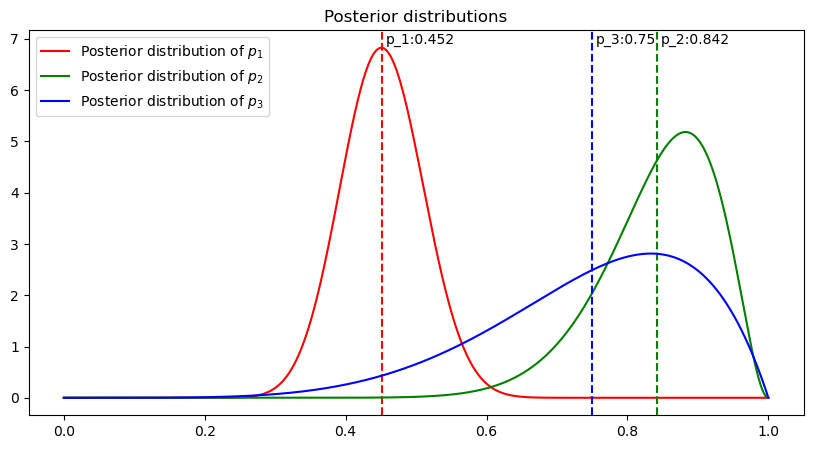

In [35]:
bins = [0, 1, 2, 3, float('inf')]

dhaka_battles['BINS'] = pd.cut(dhaka_battles['RAW_COUNTS'], bins = bins, right=False, labels=[0, 1, 2, 3])

colours = ['r', 'g', 'b']

post_params = []

hyperparams = [1, 1] # change alpha 1 and alpha 2 in the prior

fig, ax = plt.subplots(figsize=(10,5))

x_axis = np.linspace(0, 1, 1000)

for idx, (count, df) in enumerate(dhaka_battles.groupby('BINS')):
    if idx == 0:
        continue
    n0 = df.loc[df['BOOLEAN_FATAL'] == 0, 'FATALITIES'].count()
    print(f'{n0} weeks with {idx} events and no fatalities')
    n1 = df.loc[df['BOOLEAN_FATAL'] == 1, 'FATALITIES'].count()
    print(f'{n1} weeks with {idx} events and at least one fatality')
    post_params.append([hyperparams[0]+n1, hyperparams[1]+n0])
    ax.plot(x_axis, stats.beta.pdf(x_axis, hyperparams[0]+n1, hyperparams[1]+n0), label=rf'Posterior distribution of $p_{idx}$', c=colours[idx-1])
    post_mean = (hyperparams[0]+n1)/(hyperparams[0]+hyperparams[1]+n0+n1)
    ax.axvline(x=post_mean, c=colours[idx-1], linestyle='--')
    ax.text(post_mean+0.005, 6.9, f'p_{idx}:{round(post_mean, 3)}')
    print(f'Posterior mean of {post_mean} for p{idx}')

ax.legend(loc='best')
ax.set(title = 'Posterior distributions')
plt.show()

Since the beta distribution is conjugate in this scenario, it is easy to draw any required results directly from the posterior beta distribution. However, the visible problem that is being faced now is that the mean of the posterior distribution of $p_2$ is greater than that of $p_{3+}$, which contradicts the expected behaviour of the data.

To create a box and violin plot similar to that seen in the previous models, we can sample 1000 times from each of the three posterior distributions and use these samples to draw the plots.

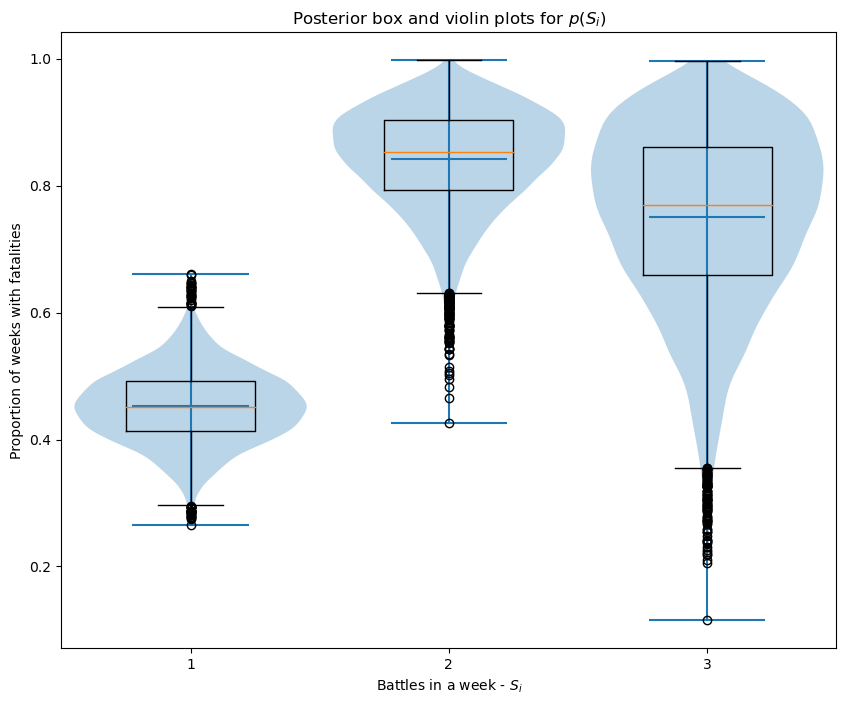

In [36]:
sim_battles = [1,2,3]

samples_mat = np.zeros((10000, 3))

for i in range(10000):
    for j in range(3):
        samples_mat[i, j] = np.random.beta(*post_params[j])

fig, ax = plt.subplots(figsize = (10, 8))

ax.violinplot(samples_mat, widths=0.9, showmeans=True, positions=sim_battles)
ax.boxplot(samples_mat, widths=0.5, positions=sim_battles)
ax.set(title=rf'Posterior box and violin plots for $p(S_i)$',
              xlabel = r'Battles in a week - $S_i$',
              ylabel = 'Proportion of weeks with fatalities')


plt.show()

This can be solved by forcing an ordering of the posterior distributions, which is implemented in the next model.

## Model Four: forcing an ordering of the posterior distributions

In [37]:
param_names = ['P3', 'P2', 'P1']

For this model I once again consider the three discrete probabilities, but employ a "stick breaking" method to enforce an ordering on the sampled posterior values. The highest level probability is denoted $p_3$, then the stick breaking is enforced with $p_2 = q_2p_3$ and $p_1=q_1p_2=q_1q_2p_3$, where $q_2,q_1 \in (0, 1)$ to ensure that $p_1<p_2<p_3$.

The priors are assigned as $p_3 \sim \mathrm{Beta}(\alpha_3, \beta_3)$, $q_2 \sim \mathrm{Beta}(\alpha_2, \beta_2)$ and $q_1 \sim \mathrm{Beta}(\alpha_1, \beta_1)$.

The likelihood is then 

\begin{equation}
    \begin{split}
        p(F|p_3, q_2, q_1) = \prod_{i=1}^{N_3} p_3^{F_3^{(i)}} (1-p_3)^{1-F_3^{(i)}} \prod_{i=1}^{N_2} (p_3q_2)^{F_2^{(i)}} (1-p_3q_2)^{1-F_2^{(i)}} \prod_{i=1}^{N_1} (p_3q_2q_1)^{F_1^{(i)}} (1-p_3q_2q_1)^{1-F_1^{(i)}}
    \end{split}
\end{equation}

where $N_k$ is the total number of weeks with $k$ events, and this leads to a log-likelihood of

\begin{equation}
    \begin{split}
        \log(p(F|p_3, q_2, q_1)) = \sum_{i=1}^{N_3} \left(F_3^{(i)}\log(p_3) + (1-F_3^{(i)})\log(1-p_3)\right) + \sum_{i=1}^{N_2} \left(F_2^{(i)}\log(p_3q_2) + (1-F_2^{(i)})\log(1-p_3q_2)\right) + \sum_{i=1}^{N_1} \left(F_1^{(i)}\log(p_3q_2q_1) + (1-F_1^{(i)})\log(1-p_3q_2q_1)\right).
    \end{split}
\end{equation}

In implementation the products inside the logarithms are further split up to maintain computation stability, but for readability this is not shown here.

This is implemented in the functions in the code cell below.

In [38]:
def mod4_lpl(params, hyperparams):
    '''
    Log prior likelihood
    '''
    lpl = 0
    for idx, param in enumerate(params):
        lpl += np.log(stats.beta.pdf(param, hyperparams[idx][0], hyperparams[idx][1]))
    return lpl

def mod4_llh(params, data):
    '''
    Log likelihood - intended to be used with the specific data frame, will probably error otherwise
    '''    
    llh = 0
    for i in range(4):
        if i == 0:
            continue
        sub_frame = data.loc[data['BINS'] == i]
        fatalities = sub_frame['BOOLEAN_FATAL'].values
        for fatal in fatalities:
            llh += fatal * np.log(np.prod(params[:i+1])) + (1-fatal) * np.log(1 - np.prod(params[:i+1]))
    return llh

def mod4_log_post_density(params, hyperparams, data):
    lpl = mod4_lpl(params, hyperparams)
    llh = mod4_llh(params, data)
    return lpl+llh

def normal_prop_dist(param, step):
    return np.random.normal(param, step)

In [39]:
param_names = ['P3', 'Q2', 'Q1']
initial_params = [0.8, 0.2, 0.2]
stepsizes = [0.01, 0.01, 0.01]
proposal_dists = [normal_prop_dist, normal_prop_dist, normal_prop_dist]
bounds = [[0, 1], [0, 1], [0, 1]]
hyperparams = [[1, 1], [1, 1], [1, 1]]

full_chain = general_mh_mcmc(mod4_log_post_density, initial_params, param_names, proposal_dists, stepsizes, 10000, bounds, hyperparams, dhaka_battles)
for idx, param in enumerate(param_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

Proposal acceptance rate of 0.9499 for parameter P3
Proposal acceptance rate of 0.9446 for parameter Q2
Proposal acceptance rate of 0.8646 for parameter Q1
Effective sample size of 8.194968888475653 for parameter P3
Effective sample size of 7.9902924964496185 for parameter Q2
Effective sample size of 83.67692982188986 for parameter Q1


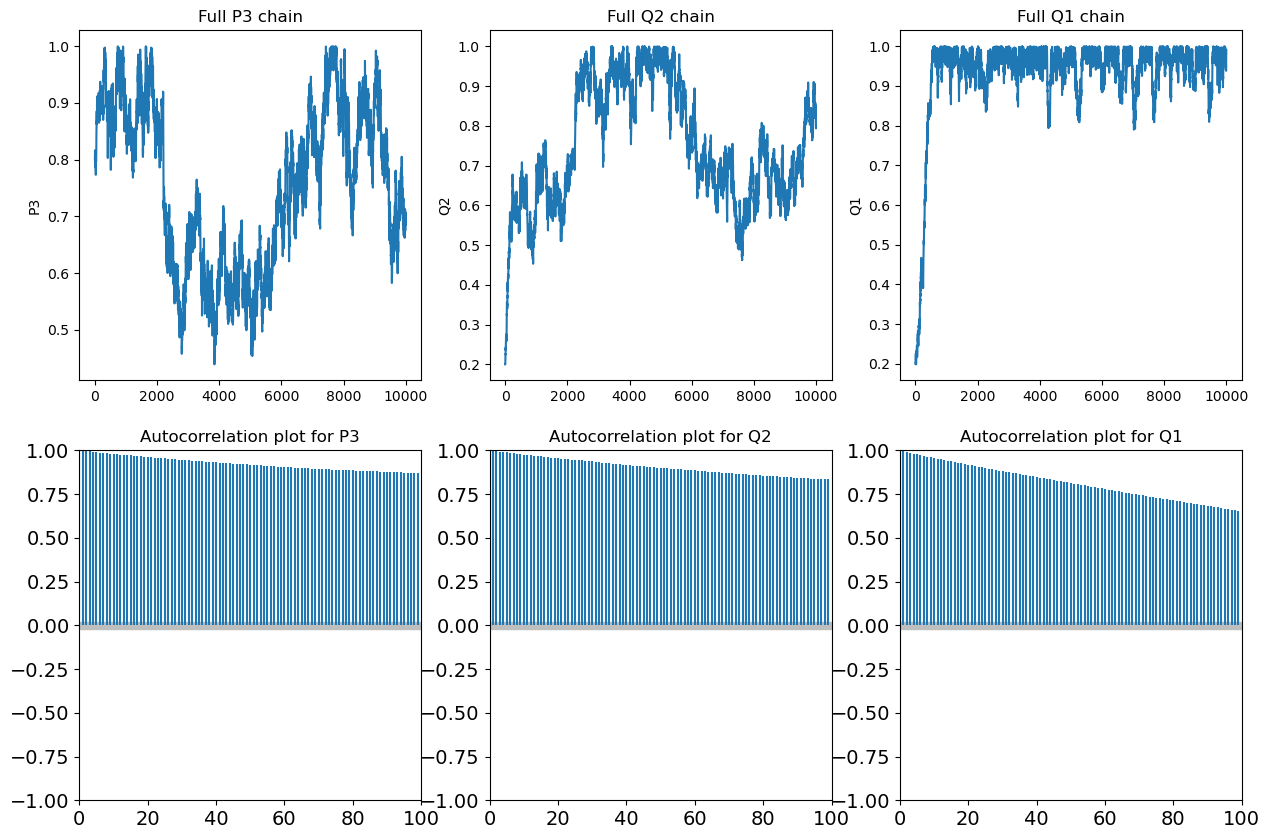

In [40]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(param_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

# sns.pairplot(full_chain)
plt.show()

In [61]:
def mod4_lpl2(p3, q2, q1):
    lpl = stats.beta.pdf(p3, 1, 1) + stats.beta.pdf(q2, 1, 1) + stats.beta.pdf(q1, 1, 1)
    return lpl

def mod4_prob(parameters, count):
    if count > 1:
        return np.prod(parameters[:-count+1])
    else:
        return np.prod(parameters)

def mod4_llh2(parameters, counts, fatalities):
    llh = 0
    for count, fatal in zip(counts, fatalities):
        prob = mod4_prob(parameters, count)

        llh += fatal*np.log(prob) + (1-fatal)*np.log(1-prob)
    return llh

def mod4_lpd(parameters, counts, fatalities):
    return mod4_lpl2(*parameters) + mod4_llh2(parameters, counts, fatalities)

counts = dhaka_battles.loc[dhaka_battles['BINS'] != 0]['BINS'].values.astype(int)
fatalities = dhaka_battles.loc[dhaka_battles['BINS'] != 0]['BOOLEAN_FATAL'].values

def logistic(x):
    return 1/(1+np.exp(-x))

def inv_logistic(x):
    return np.log(x/(1-x))

In [62]:
def mod4_lpl2(parameters, hyperparameters):
    lpl = 0
    for param, hypers in zip(parameters, hyperparameters):
        lpl += stats.beta.pdf(param, hypers[0], hypers[1])
    return lpl

def mod4_prob(parameters, count):
    if count > 1:
        return np.prod(parameters[:-count+1])
    else:
        return np.prod(parameters)

def mod4_llh2(parameters, counts, fatalities):
    llh = 0
    for count, fatal in zip(counts, fatalities):
        prob = mod4_prob(parameters, count)

        llh += fatal*np.log(prob) + (1-fatal)*np.log(1-prob)
    return llh

def mod4_lpd(parameters, counts, fatalities, hyperparameters):
    return mod4_lpl2(parameters, hyperparameters) + mod4_llh2(parameters, counts, fatalities)

In [65]:
def mod4_mh_mcmc(iterations, stepsizes, target, initial_params, param_names, hyperparams, observations, responses):
    num_params = len(initial_params)
    samples = np.zeros((iterations+1, num_params))
    samples[0,:] = initial_params
    current_params = initial_params
    acceptance_count = np.zeros(num_params)

    for iter in range(iterations):
        for idx, param in enumerate(current_params):
            # propose the same parameters, changing the appropriate parameter only
            # this is a messy method but I'd not realised that lists aren't immutable
            current_unconstrained = inv_logistic(param)
            proposed_unconstrained = current_unconstrained + np.random.normal(scale=abs(np.log(stepsizes[idx])))
            proposed_param = logistic(proposed_unconstrained)
            proposed_params = np.zeros(num_params)
            proposed_params[:idx] = current_params[:idx]
            proposed_params[idx] = proposed_param
            if idx != num_params-1:
                proposed_params[idx+1:] = current_params[idx+1:]

            # find the target log densities under the current and proposed parameters, and the acceptance ratio
            log_post_current = target(current_params, observations, responses, hyperparams)
            log_post_proposed = target(proposed_params, observations, responses, hyperparams)
            acceptance_ratio = log_post_proposed - log_post_current

            if acceptance_ratio > np.log(np.random.rand()):
                # if accepted, update the parameters
                current_params = proposed_params
                acceptance_count[idx] += 1
                samples[iter+1, idx] = proposed_param
            
            else:
                samples[iter+1, idx] = param

    for idx, param in enumerate(param_names):
        print(f'Proposal acceptance rate of {acceptance_count[idx]/iterations} for parameter {param}')

    return_frame = pd.DataFrame(samples, columns = param_names)
    return return_frame

In [66]:
param_names = ['P3', 'Q2', 'Q1']
initial_params = [0.8, 0.2, 0.2]
stepsizes = [0.2, 0.01, 0.2]
proposal_dists = [normal_prop_dist, normal_prop_dist, normal_prop_dist]
hyperparams = [[1, 1], [1, 1], [1, 1]]
counts = dhaka_battles.loc[dhaka_battles['BINS'] != 0]['BINS'].values.astype(int)
fatalities = dhaka_battles.loc[dhaka_battles['BINS'] != 0]['BOOLEAN_FATAL'].values

np.random.seed(1)

full_chain = mod4_mh_mcmc(iterations=10000, stepsizes=stepsizes, target=mod4_lpd,
                          initial_params=[0.8, 0.9, 0.5], param_names=['P3', 'Q2', 'Q1'], hyperparams=hyperparams,
                          observations=counts, responses=fatalities)

for idx, param in enumerate(param_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

/tmp/ipykernel_69279/989118936.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(x/(1-x))


Proposal acceptance rate of 0.3627 for parameter P3
Proposal acceptance rate of 0.999 for parameter Q2
Proposal acceptance rate of 0.2186 for parameter Q1
Effective sample size of 1007.7792545269477 for parameter P3
Effective sample size of 58.64159565331489 for parameter Q2
Effective sample size of 808.0092675915128 for parameter Q1


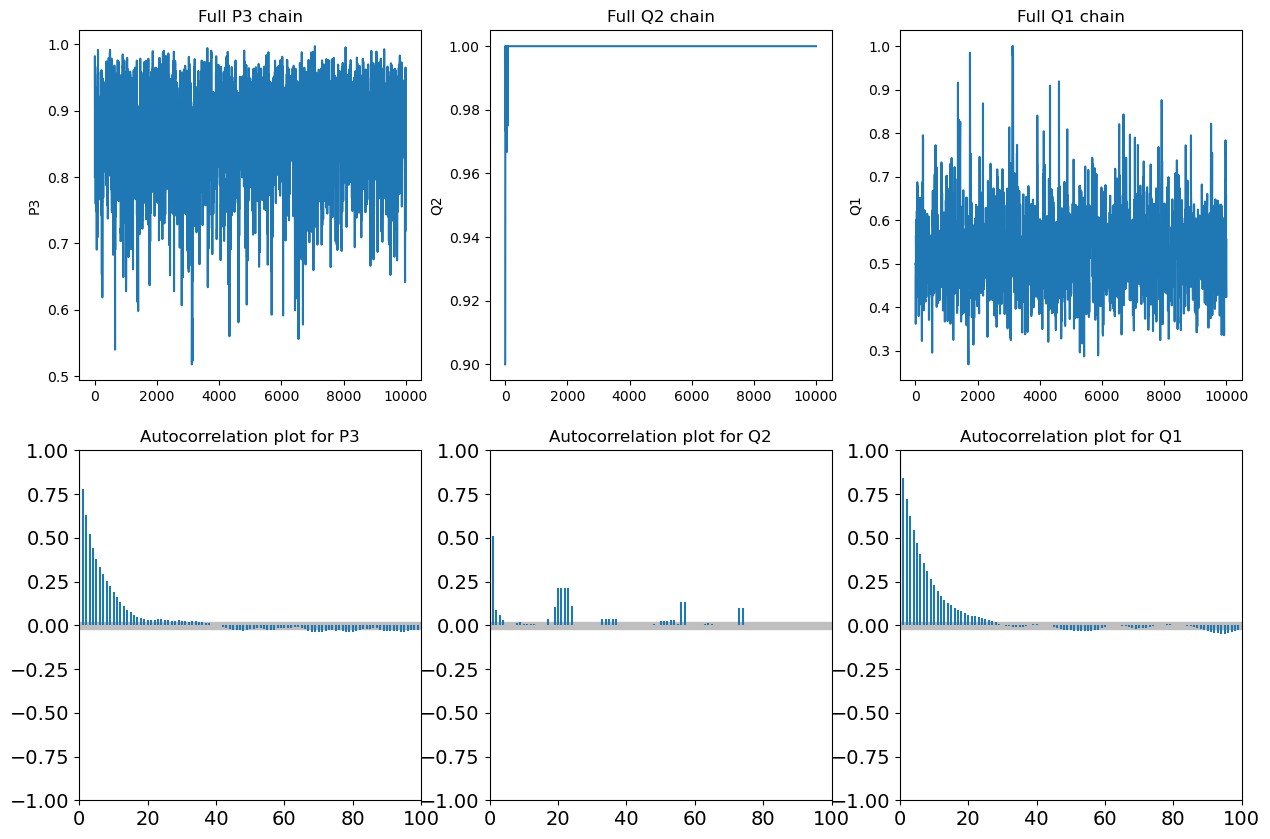

In [67]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(param_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

# sns.pairplot(full_chain)
plt.show()

This implementation produces a better result than the sampler which does not transform from $[0,1]$ to the real line. The poor sampling of the $q_2$ parameter I believe is in this case specifically due to the data, which have $p_2 > p_3$, and so the sampler is still struggling to force the ordering. An alternative to transforming or limiting parameters is to use a proposal distribution which samples only from the parameter space.

Another distribution to try as a proposal is $\mathrm{Unif(0,1)}$ which is naturally limited to $[0,1]$ so there is no need for sample transformation. However, this does not define a Markov Chain in the same way as a more involved proposal distribution, as the next step in the chain is dependent on no other steps, including not being dependent on the current state of the chain. This defeats the point of Markov Chain Monte Carlo sampling. However, it should be noted that $\mathrm{Unif}(0,1)$ is the same distribution as $\mathrm{Beta}(1,1)$. All $\mathrm{Beta}(\alpha, \beta)$ distributions have their support as $(0,1)$ which suggests that they would form a suitable proposal distribution for the algorithm.

When using a normal or uniform proposal distribution, in each iteration of the Markov Chain the future state depends on the current value of the parameter, which is taken as the mean of the proposal distribution, and the "spread" of the proposal distribution is defined at the start of the algorithm as the stepsize which is used. As an example, the proposal distribution which has been used throughout the analysis until now is the Normal distribution, with stepsize corresponding to the standard deviation. This means that the next state of the chain depends on only the current state (the Markov property), and the defined stepsize means that the chain takes some point in the parameter space neighbourhood of the current state.

To recreate this with the beta distribution, we must find a way to find the $\alpha$ and $\beta$ parameters given a mean and variance, where in this implementation the stepsize will be used as the variance of the proposal distribution. Given $X\sim\mathrm{Beta}(\alpha,\beta)$, we have that $\mu_X = \frac{\alpha}{\alpha+\beta}$ and $\sigma_X^2 = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$. Therefore, given a $\mu$ and $\sigma^2$, the parameters for the Beta distribution are

\begin{equation}
    \alpha = \left(\frac{1-\mu}{\sigma^2} - \frac{1}{\mu}\right)\mu^2 \qquad \text{and} \qquad \beta = \alpha\left(\frac{1}{\mu} - 1\right)
\end{equation}

where $\mu \in (0, 1)$ and $\sigma^2 \in (0, \mu(1-\mu))$. The form given above can easily be verified algebraically. The constraints on $\mu$ and $\sigma^2$ will have to be considered when implementing the algorithm; indeed, it may be necessary to adjust the stepsize during each iteration to accommodate this by taking $\sigma^2_{\mathrm{iter}} = \min\{\sigma^2, \mu_\mathrm{iter}(1-\mu_\mathrm{iter})\}$ where $\sigma^2$ is the supplied stepsize, and $\mu_\mathrm{iter}$ is the current value of the parameter being sampled.

The final consideration to be taken in this new implementation is that the proposal distribution is no longer symmetrical, and this assymmetricity needs to be accounted for in the calculation of the acceptance ratio.

The cell below contains the functions required for the implementation.

In [2]:
def beta_from_mean_var(mean, variance):
    if mean <= 0 or mean >= 1:
        print(f'mean of {mean}')
        print(f'variance of {variance}')
        raise ValueError('The mean must be in (0,1)')
    if variance <= 0 or variance >= mean*(1-mean):
        print(f'mean of {mean}')
        print(f'variance of {variance}')
        raise ValueError('The variance must be in (0, mu(1-mu))')
    alpha = ( (1-mean)/variance - 1/mean ) * mean**2
    beta = alpha * (1/mean - 1)
    return alpha, beta

def beta_proposal_mh_mcmc(data, parameter_names, initial_parameters, stepsizes, hyperparameters, target, iterations=10000, mu_variance_power=1):
    num_params = len(parameter_names)
    params_chain = np.zeros((iterations+1, num_params))
    params_chain[0,:] = initial_parameters

    # initialise parameters and acceptance rates
    current_params = initial_parameters
    param_acceptance_count = np.zeros(num_params)
    stepsize_use_count = np.zeros(num_params)

    for i in range(iterations):
        for idx, param in enumerate(current_params):
            # find the variance and parameters for the beta distribution
            iter_var = min(stepsizes[idx], (param**mu_variance_power)*(1-param))
            if iter_var == stepsizes[idx]:
                stepsize_use_count[idx] += 1
            # propose parameter
            current_a, current_b = beta_from_mean_var(param, iter_var)
            proposed_param = np.random.beta(current_a, current_b)
            # update proposed parameters
            proposed_params = np.zeros(num_params)
            proposed_params[:idx] = current_params[:idx]
            proposed_params[idx] = proposed_param
            if idx != num_params-1:
                proposed_params[idx+1:] = current_params[idx+1:]

            # find the chain ratio from the transition probabilities
            new_iter_var = min(stepsizes[idx], proposed_param*(1-proposed_param)-(1e-10))
            new_a, new_b = beta_from_mean_var(proposed_param, new_iter_var)
            chain_ratio = stats.beta.logpdf(param, a=new_a, b=new_b) - stats.beta.logpdf(proposed_param, a=current_a, b=current_b)

            # find the posterior ratio
            post_ratio = target(proposed_params, hyperparameters, data) - target(current_params, hyperparameters, data)

            # accept or reject
            if chain_ratio + post_ratio > np.log(np.random.rand()):
                params_chain[i+1, idx] = proposed_param
                current_params = proposed_params
                param_acceptance_count[idx] += 1
            else:
                params_chain[i+1, idx] = param

    for idx, param in enumerate(parameter_names):
        print(f'Proposal acceptance rate of {param_acceptance_count[idx]/iterations} for parameter {param}')
        print(f'Stepsize usage of parameter {param} was {stepsize_use_count[idx]/iterations}')

    params_chain_frame = pd.DataFrame(params_chain, columns = parameter_names)

    return params_chain_frame

In [46]:
np.random.seed(1)

parameter_names = ['p3', 'q2', 'q1']
initial_params = [0.8, 0.5, 0.5]
stepsizes = [0.0001, 0.0001, 0.0001]
hyperparams = [[1,1], [1,1], [1,1]]

full_chain = beta_proposal_mh_mcmc(dhaka_battles, parameter_names, initial_params, stepsizes, hyperparams, mod4_log_post_density, iterations=1000, mu_variance_power=4)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

mean of 1.0
variance of -1e-10


ValueError: The mean must be in (0,1)

KeyError: 'p3'

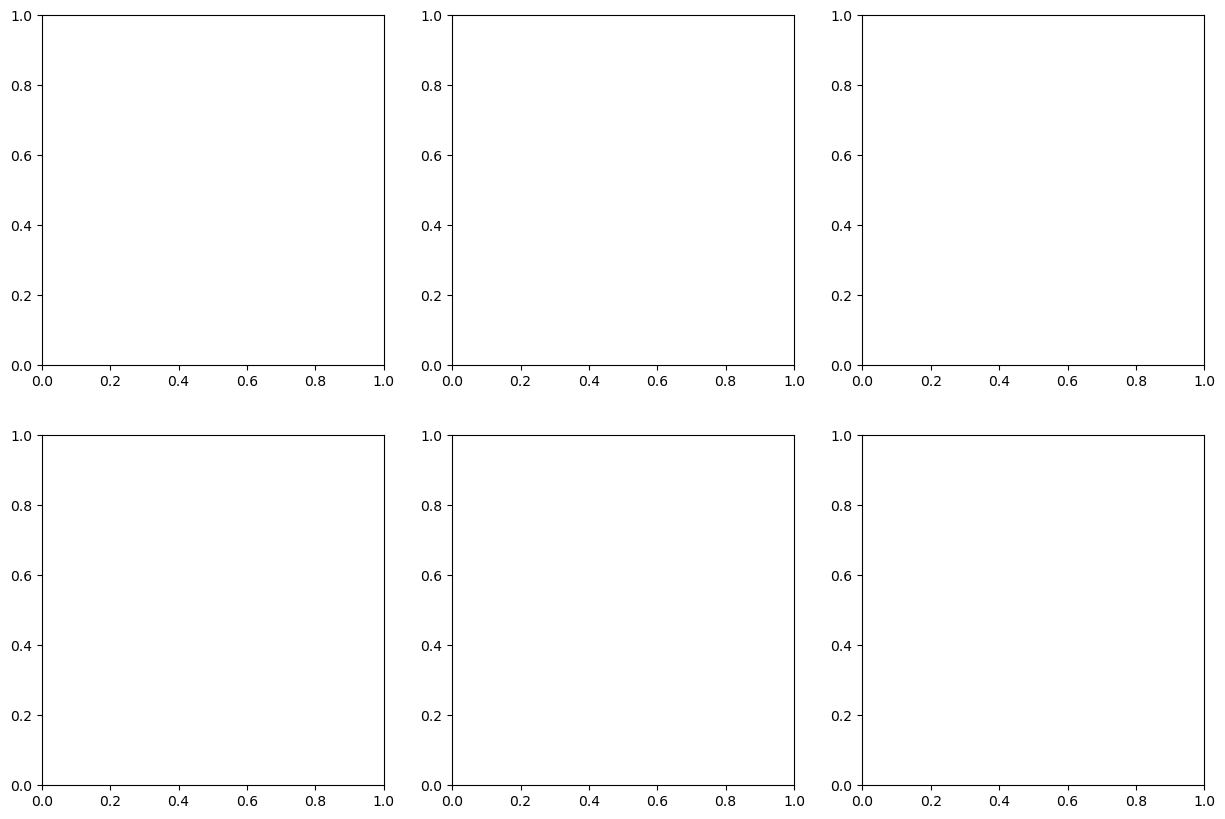

In [47]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(parameter_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

# sns.pairplot(full_chain)
plt.show()

Unfortunately the algorithm is still unable to cope with this model, as the sampler tends inevitably and quickly to sampling either $0$ or $1$ for at least one of the parameters, which is an invalid value for the mean of the beta distribution. From experimentation, it is not possible to correct the mean value as this just causes the parameters to converge on either the upper or the lower bound of the correction. It is also not possible to nudge the mean of the distribution when sampling further as this also just causes samples to be taken which still converge to $1$. I believe this is due to the shape of a beta distribution which is constructed to have a particular variance being likely to have most of its density near $0$ or $1$.

A suggested solution to this problem is to adjust the variance even further. Since the variance of the beta distribution is constrained by $\sigma^2 \in (0,\mu(1-\mu))$, using $\mu(1-\mu)$ as the variance may be causing issues as the variance is too large in some sense. I run the implementation again using the variance as $\mu^2(1-\mu)$ in each iteration to see the effect that this higher restriction on the variance has.

In [48]:
parameter_names = ['p3', 'q2', 'q1']
initial_params = [0.5, 0.5, 0.5]
stepsizes = [1e-4, 1e-4, 1e-4]
hyperparams = [[1,1], [1,1], [1,1]]

full_chain = beta_proposal_mh_mcmc(dhaka_battles, parameter_names, initial_params, stepsizes, hyperparams, mod4_log_post_density, iterations=1000, mu_variance_power=2)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

mean of 0.9999999999967278
variance of -9.672783967953298e-11


ValueError: The variance must be in (0, mu(1-mu))

I now turn to the suggestion of using the uniform distribution as the proposal. This will have the advantage that it will not have problems in sampling, no matter where the chain is, since the sampling does not depend on the position of the chain. In addition, where problems have arisen before in the chain converging to $1$ and not exploring the sample space, the uniform distribution will sample (uniformly, of course) from the entire parameter space. Furthermore, using the uniform distribution brings the proposal distribution back to being symmetrical, so transition probabilities need not be calculated.

The implementation of the uniform proposal distribution is in the cell below.

In [49]:
def unif_proposal_mh_mcmc(data, parameter_names, initial_parameters, hyperparameters, target, iterations=10000):
    num_params = len(parameter_names)
    params_chain = np.zeros((iterations+1, num_params))
    params_chain[0,:] = initial_parameters

    # initialise parameters and acceptance rates
    current_params = initial_parameters
    param_acceptance_count = np.zeros(num_params)

    for i in range(iterations):
        for idx, param in enumerate(current_params):
            proposed_param = np.random.rand()
            # update proposed parameters
            proposed_params = np.zeros(num_params)
            proposed_params[:idx] = current_params[:idx]
            proposed_params[idx] = proposed_param
            if idx != num_params-1:
                proposed_params[idx+1:] = current_params[idx+1:]

            # find the posterior ratio
            acceptance_ratio = target(proposed_params, hyperparameters, data) - target(current_params, hyperparameters, data)

            # accept or reject
            if acceptance_ratio > np.log(np.random.rand()):
                params_chain[i+1, idx] = proposed_param
                current_params = proposed_params
                param_acceptance_count[idx] += 1
            else:
                params_chain[i+1, idx] = param

    for idx, param in enumerate(parameter_names):
        print(f'Proposal acceptance rate of {param_acceptance_count[idx]/iterations} for parameter {param}')

    params_chain_frame = pd.DataFrame(params_chain, columns = parameter_names)

    return params_chain_frame

In [50]:
parameter_names = ['p3', 'q2', 'q1']
initial_params = [0.5, 0.5, 0.5]
hyperparams = [[1,1], [1,1], [1,1]]

full_chain = unif_proposal_mh_mcmc(dhaka_battles, parameter_names, initial_params, hyperparams, mod4_log_post_density, iterations=1000)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

Proposal acceptance rate of 0.205 for parameter p3
Proposal acceptance rate of 0.188 for parameter q2
Proposal acceptance rate of 0.112 for parameter q1
Effective sample size of 21.468952679890375 for parameter p3
Effective sample size of 19.143559763052547 for parameter q2
Effective sample size of 58.22326608855842 for parameter q1


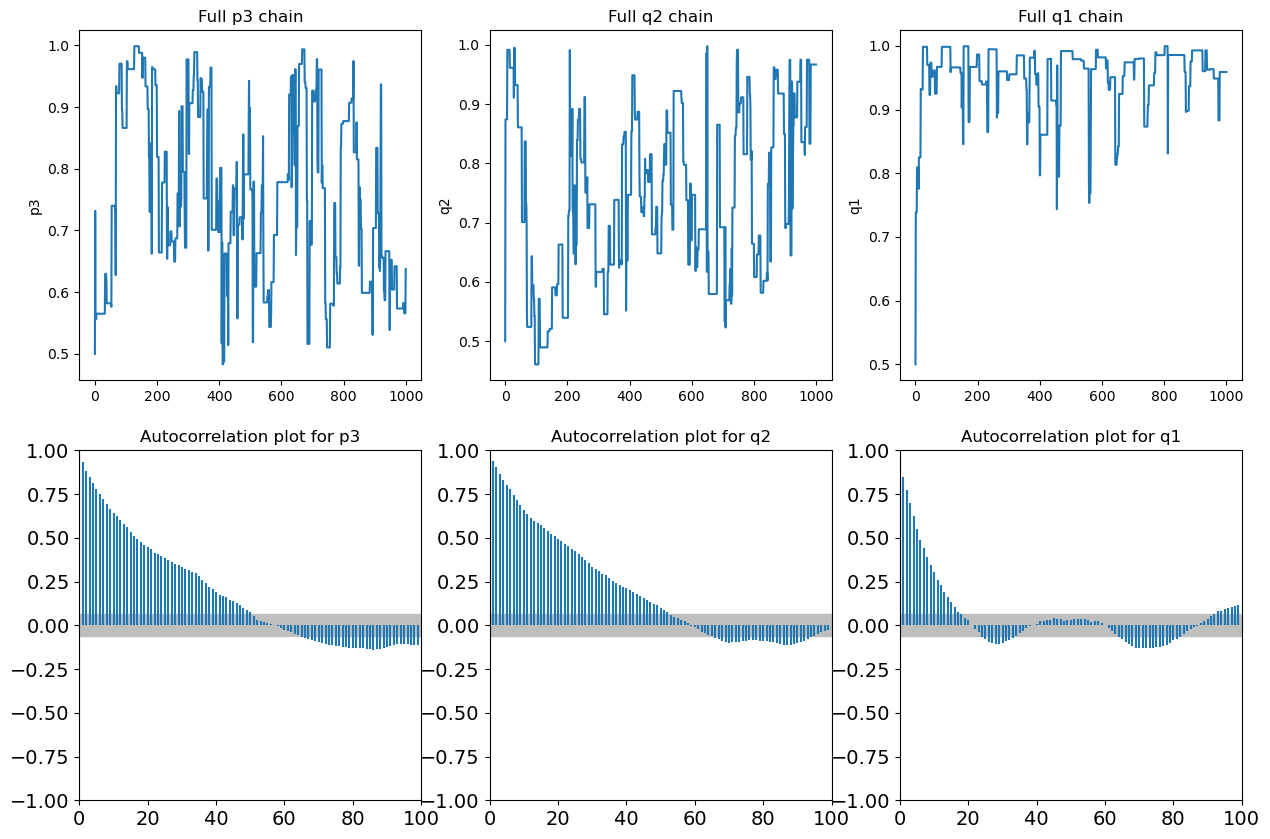

In [51]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for idx, param in enumerate(parameter_names):
    ax[0, idx].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[1, idx])
    ax[0, idx].set(title = f'Full {param} chain',
                   ylabel = f'{param}')
    ax[1, idx].set(title = f'Autocorrelation plot for {param}')

# sns.pairplot(full_chain)
plt.show()

Whilst this change has allowed the sampler to run without raising an error, it now seems that once again the parameters converge to $1$. 

Having seen a number of methods for sampling from the posterior distribution for this model, it is evident that the best one is to transform the sampling parameters into a sample space from which it is easier to sample. However, this did not seem to be able to capture behaviour where $p_3 < p_2$ in the observed data, and for a better insight into this behaviour it would be better to use Stan.

## Model 5: How does a wider region affect fatalities in the inner region - Dhaka?

It may be of interest to know how the events and fatalities occuring in a wider region affect the number of fatalities. We already have a number of models relating the number of events $S_i$ and the presence of a fatality $F_i$ within one region, or if desired, over the whole country. Continuing the example of Dhaka, consider the Admin 2 region of Dhaka and the Admin 1 region of Dhaka - that is, consider the district of Dhaka within the larger division of Dhaka. We can define the following variables:
* $F_i$ - the presence of a fatality in Dhaka district in week $i$;
* $S_i$ - the number of events in Dhaka district in week $i$;
* $R_i$ - the number of events in Dhaka division excluding Dhaka district in week $i$;
* $G_i$ - the presence of a fatality in Dhaka division excluding Dhaka district in week $i$; and
* $p_i$ - the probability that week $i$ sees a fatality in Dhaka district.

There are several different models that could be considered resulting from this analysis, the most general of these being the logistic regression

\begin{equation}
    p_i = \frac{\exp(\alpha + \beta_1 S_i + \beta_2 S_{i-1} + \beta_3 F_{i-1} + \beta_4 R_i + \beta_5 R_{i-1} + \beta_6 G_i + \beta_7 G_{i-1})}{1 + \exp(\alpha + \beta_1 S_i + \beta_2 S_{i-1} + \beta_3 F_{i-1} + \beta_4 R_i + \beta_5 R_{i-1} + \beta_6 G_i + \beta_7 G_{i-1})}.
\end{equation}

Some discussion can be had about the various $\beta$ parameters
* $\beta_1$ - this parameter has already been modelled, and naturally the number of events in the district will have an effect on the proportion of weeks with fatalities;
* $\beta_2$ - this parameter has not yet been modelled, so may be out of the scope of interest;
* $\beta_3$ - fatalities in the previous week may increase the pressure on services within the region of interest, meaning that there is likely to be an elevated chance of a fatality no matter the number of events;
* $\beta_4$ - it is possible to imagine that events happening in the wider region could spark deaths in the inner region, although this is likely to be via other events being sparked in the inner region;
* $\beta_5$ - once again events happening in the previous week may affect in some way the fatalities of the current week, but again this is likely to occur through the sparking of other events;
* $\beta_6$ - fatalities in the wider region may increase pressure on services in the inner region, leading to an increase in fatalities occurring in the inner region;
* $\beta_7$ - with a similar justification as $\beta_6$, there may be a residual pressure on services in the inner region due to fatalities in the outer region in the previous week.

For the data where happenings in the outer region are considered as covariates for the model considering the inner region, the inner region is excluded from this covariate data so as not to have events and fatalities in the inner region represented twice in the modelling.

### Sampling

Since these models are all a logistic regression with a varying number of covariates, it is possible to use the `logit_mh_mcmc` function when sampling from the posterior distributions. 

In [ ]:
wider_battles = data.loc[data['ADMIN1'] == 'Dhaka'].loc[data['ADM2_name'] != 'Dhaka'].groupby('WEEK', as_index=False)[['RAW_COUNTS', 'FATALITIES']].sum()

wider_battles['BOOLEAN_FATAL'] = wider_battles['FATALITIES'].gt(0).astype(int)

wider_fatalities = wider_battles['BOOLEAN_FATAL'].values[1:]
wider_prev_fatal = wider_battles['BOOLEAN_FATAL'].values[:-1]
wider_event_count = wider_battles['RAW_COUNTS'].values
event_counts = dhaka_battles['RAW_COUNTS'].values
fatalities = dhaka_battles['BOOLEAN_FATAL'].values

In [ ]:
mod5_covariates = np.column_stack([event_counts[1:], event_counts[:-1], fatalities[:-1], wider_event_count[1:], wider_event_count[:-1], wider_fatalities, wider_prev_fatal])
mod5_responses = fatalities[1:]

In [ ]:
mod5_covariates.shape

(626, 7)

In [ ]:
mod2_covs.shape

(626, 2)

In [ ]:
initial_params = list(minimize(neg_llh, [0] * 8, (mod5_responses, mod5_covariates), method='L-BFGS-B').x)

In [ ]:
logit_ll([0]*8, mod5_responses, mod5_covariates)

-433.9101350305258

In [ ]:
initial_params

[-5.53031491842731,
 4.330114796295106,
 -0.02590836948175331,
 1.6058774961345366,
 -0.06220550472492457,
 0.0019831967938687975,
 1.6116798934600978,
 -0.7711672220462492]

In [ ]:
np.random.seed(1)
parameter_names = ['alpha', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'beta7']
param_steps = [0.7, 0.7, 1.0, 1.0, 0.1, 0.1, 1.0, 1.0]                                      # stepsize for the Metropolis-Hastings proposal distributions
hyperparams = [[0, 1]] * 8                        # hyperparameters - mean, sd for the priors
proposal_dists = [proposal_alpha] * 8    # proposal distributions for the Metropolis-Hastings
iterations = 10000

full_chain = logit_mh_mcmc(fatalities[1:], mod5_covariates, parameter_names, initial_params, param_steps, hyperparams, proposal_dists, logit_lpd, iterations)

for idx, param in enumerate(parameter_names):
    ess = az.ess(full_chain[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

Proposal acceptance rate of 0.3193 for parameter alpha
Proposal acceptance rate of 0.3588 for parameter beta1
Proposal acceptance rate of 0.2385 for parameter beta2
Proposal acceptance rate of 0.4845 for parameter beta3
Proposal acceptance rate of 0.4166 for parameter beta4
Proposal acceptance rate of 0.4199 for parameter beta5
Proposal acceptance rate of 0.2987 for parameter beta6
Proposal acceptance rate of 0.3746 for parameter beta7
Effective sample size of 335.8077567939739 for parameter alpha
Effective sample size of 659.5007198244421 for parameter beta1
Effective sample size of 630.4385756503023 for parameter beta2
Effective sample size of 722.0969273021326 for parameter beta3
Effective sample size of 677.0127407936776 for parameter beta4
Effective sample size of 604.0113708278808 for parameter beta5
Effective sample size of 582.1027333137359 for parameter beta6
Effective sample size of 842.2721656645269 for parameter beta7


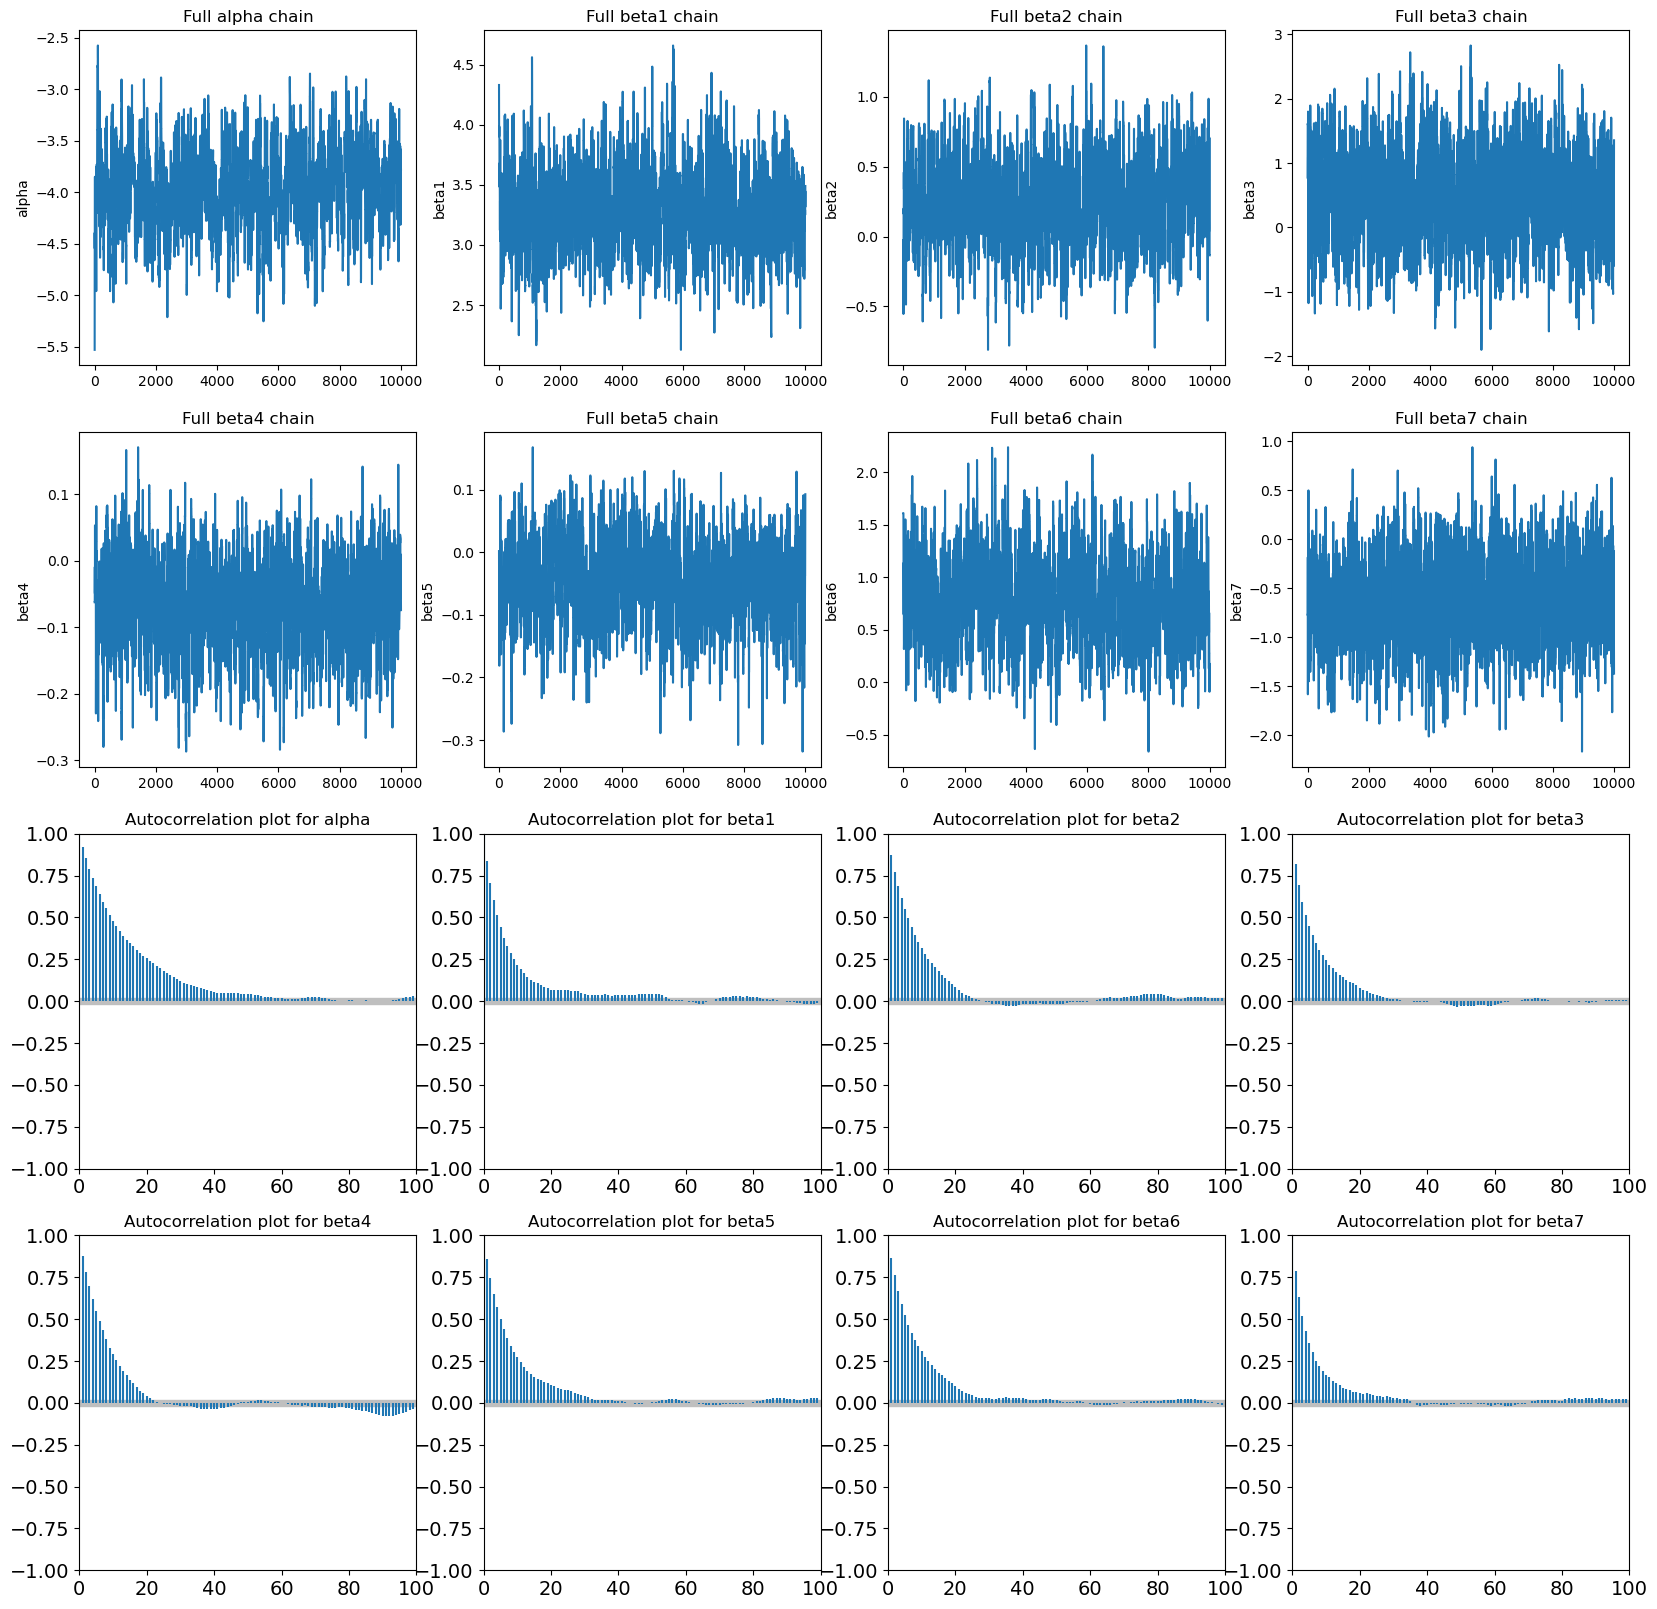

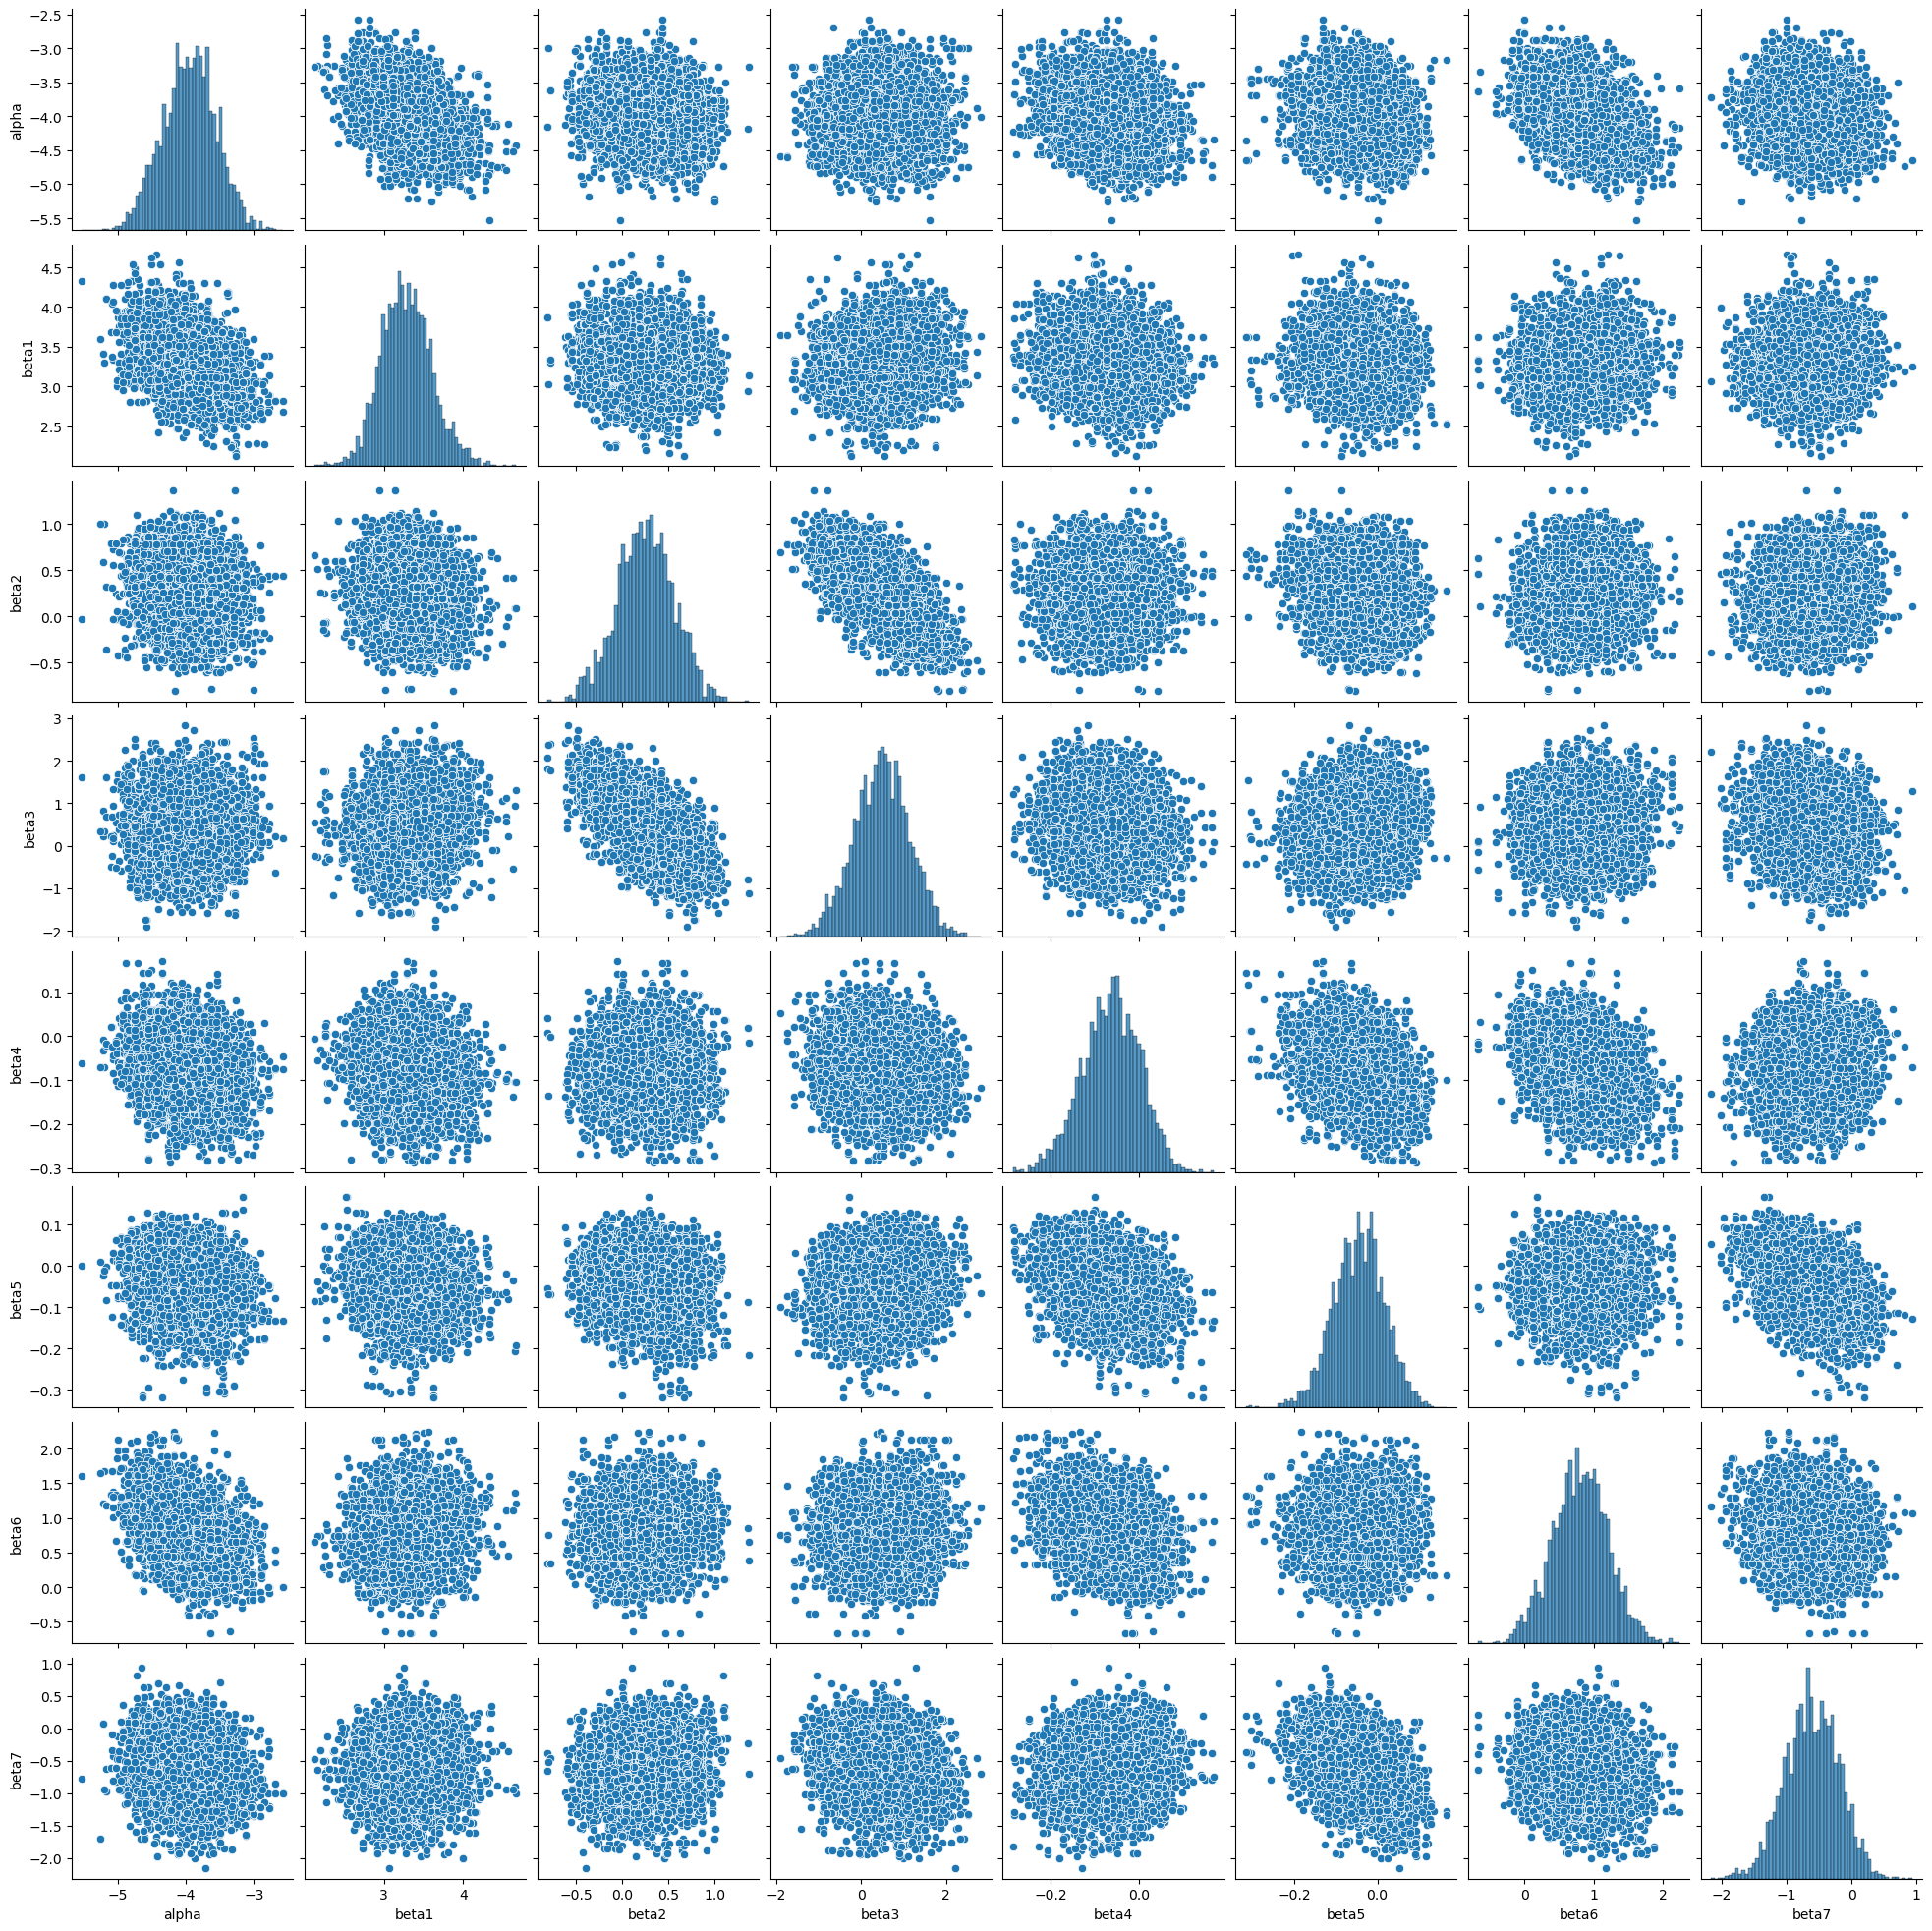

In [ ]:
fig, ax = plt.subplots(4, 4, figsize = (20, 20))

for idx, param in enumerate(parameter_names):
    ax[idx//4, idx%4].plot(full_chain[param])
    az.plot_autocorr(full_chain[param].values, ax=ax[2+idx//4, idx%4])
    ax[idx//4, idx%4].set(title = f'Full {param} chain',
                   ylabel = f'{param}') 
    ax[2+idx//4, idx%4].set(title = f'Autocorrelation plot for {param}')

sns.pairplot(full_chain)
plt.show()